# Проект: Обучение с учителем: качество модели

## Описание проекта
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 

Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Необходимые импорты

In [122]:
!pip install shap phik numpy -q

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import shap
import phik
from phik.report import plot_correlation_matrix
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    roc_auc_score, 
    recall_score, 
    precision_score)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


# загружаем класс pipeline
from sklearn.pipeline import Pipeline
# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures, LabelEncoder
from sklearn.compose import ColumnTransformer


# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, roc_curve

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score

from sklearn.feature_selection import SelectKBest, f_classif


# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance


from sklearn.exceptions import ConvergenceWarning
from sklearn.tree import export_text
from sklearn.tree import plot_tree

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [1]:
import sklearn
sklearn.__version__

'0.24.1'

In [7]:
sns.set_theme()

In [8]:
RANDOM_STATE = 42
TEST_SIZE = .25
DEFAULT_COLOR = '#8174A0'

In [9]:
def add_bar_labels(ax):
    """
    Добавляет метки к столбикам диаграммы, поддерживает старые версии matplotlib.
    """
    if hasattr(ax, 'bar_label') and len(ax.containers) > 0:  # Для новых версий matplotlib
        for container in ax.containers:
            # print(f"Container: {container.datavalues}")  # Отладочная информация
            ax.bar_label(container, fmt=f'%.2f', label_type='edge')  # Поменяйте формат при необходимости
    else:  # Для старых версий matplotlib
        for bar in ax.patches:
            # Получаем значение столбца
            bar_value = bar.get_width() if bar.get_width() > 0 else bar.get_height()
            
            # Если значение слишком маленькое, преобразуем его в текст с двумя знаками после запятой
            text = f'{bar_value:.2f}' if bar_value < 1 else f'{int(bar_value)}'
            
            # Определяем положение текста
            if bar.get_width() > 0:  # Горизонтальная диаграмма
                x_pos = bar.get_x() + bar.get_width() + 0.1
                y_pos = bar.get_y() + bar.get_height() / 2
            else:  # Вертикальная диаграмма
                x_pos = bar.get_x() + bar.get_width() / 2
                y_pos = bar.get_y() + bar.get_height() + 0.1
            
            # print(f"Bar value: {bar_value}, x: {x_pos}, y: {y_pos}")  # Отладочная информация
            
            # Добавляем текст
            ax.text(x_pos, y_pos, text, ha='center', va='center')
    
    plt.tight_layout()  # Компактное размещение графика


In [10]:
def detect_outliers(df: pd.DataFrame, column_name: str, strategy: str):
    if strategy == 'triple_sigma':
        mean = df[column_name].mean()
        std = df[column_name].std()
        return df.query(f'~( @mean - 3 * @std < {column_name} < @mean + 3 * @std)')
    elif strategy == 'iqr':
        q25 = df[column_name].quantile(.25)
        q75 = df[column_name].quantile(.75)
        iqr = q75 - q25
        return df.query(f'~( @q25 - 1.5 * @iqr < {column_name} < @q75 + 1.5 * @iqr)')

In [11]:
def outliers_report(df: pd.DataFrame, column_names , strategy: str):
    report = []
    for cn in column_names:
        if strategy == 'triple_sigma':
            mean = df[cn].mean()
            std = df[cn].std()
            report.append({
            'column_name': cn,
            'left outliers count': df.query(f'@mean - 3 * @std > {cn}').shape[0],
            'left outliers %': df.query(f'@mean - 3 * @std > {cn}').shape[0] / df.shape[0] * 100,
            
            'right outliers count': df.query(f'@mean + 3 * @std < {cn}').shape[0],
            'right outliers %': df.query(f'@mean + 3 * @std < {cn}').shape[0] / df.shape[0] * 100   
        })
        elif strategy == 'iqr':
            q25 = df[cn].quantile(.25)
            q75 = df[cn].quantile(.75)
            iqr = q75 - q25
            report.append({
            'column_name': cn,
            'left outliers count': df.query(f'@q25 - 1.5 * @iqr > {cn}').shape[0],
            'left outliers %': df.query(f'@q25 - 1.5 * @iqr > {cn}').shape[0] / df.shape[0] * 100,
            
            'right outliers count': df.query(f'@q75 + 1.5 * @iqr < {cn}').shape[0],
            'right outliers %': df.query(f'@q75 + 1.5 * @iqr < {cn}').shape[0] / df.shape[0] * 100 
        })
    return pd.DataFrame(report).round(2)


In [12]:
def plot_graphics(df, column_name, bins=30, range_hist=None, hist_color='#519872', boxplot_color='#B9D2D2', col_alias='', xlabel='', ylabel=''):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1 = sns.histplot(data=df, x=column_name, ax=ax[0], bins=bins, binrange=range_hist, color=hist_color)
    ax1.set_title(f'Гистограмма столбца {col_alias if len(col_alias) > 0 else column_name}')
    
    ax2 = sns.boxplot(data=df, x=column_name, ax=ax[1], color=boxplot_color)
    ax2.set_title(f'Коробчатая диаграмма столбца {col_alias if len(col_alias) > 0 else column_name}')

    
    ax1.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
    ax1.set_ylabel(ylabel if len(ylabel) > 0 else 'Количество')
    ax2.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения') 

In [13]:
def process_outliers(df: pd.DataFrame, column_name: str, strategy: str, do: str):
    df = df.copy()
    if strategy == 'triple_sigma':
        mean = df[column_name].mean()
        std = df[column_name].std()
        if do == 'delete':
            return df.query(f'(@mean - 3 * @std < {column_name} < @mean + 3 * @std)')
        elif do == 'fill_na':
            df.loc[~(mean - 3 * std < df[f'{column_name}']) | ~(df[f'{column_name}'] < mean + 3 * std), f'{column_name}'] = np.nan
            return df
    elif strategy == 'iqr':
        q25 = df[column_name].quantile(.25)
        q75 = df[column_name].quantile(.75)
        iqr = q75 - q25
        if do == 'delete':
            return df.query(f'( @q25 - 1.5 * @iqr < {column_name} < @q75 + 1.5 * @iqr)')
        elif do == 'fill_na':
            df.loc[~(q25 - 1.5 * iqr < df[f'{column_name}']) | ~(df[f'{column_name}'] < q75 + 1.5 * iqr), f'{column_name}'] = np.nan
            return df

## Датасет `market_file.csv`

In [ ]:
try:
    market_file = pd.read_csv('/datasets/market_file.csv')
except:
    market_file = pd.read_csv('<Path>')

In [15]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [16]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

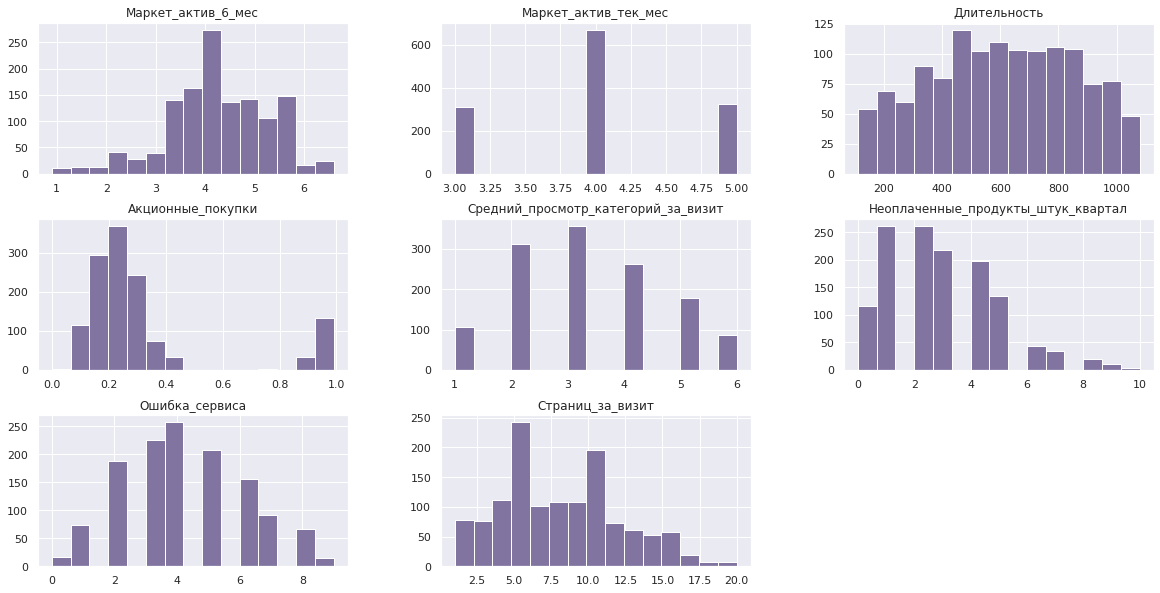

In [17]:
(market_file
 .drop(columns='id')
 .hist(
     figsize=(20, 10), 
     bins=15,
     color=DEFAULT_COLOR
 ));

### Исследование на пропуски

In [18]:
market_file.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

### Исследование на дубликаты

In [19]:
market_file.duplicated().sum()

np.int64(0)

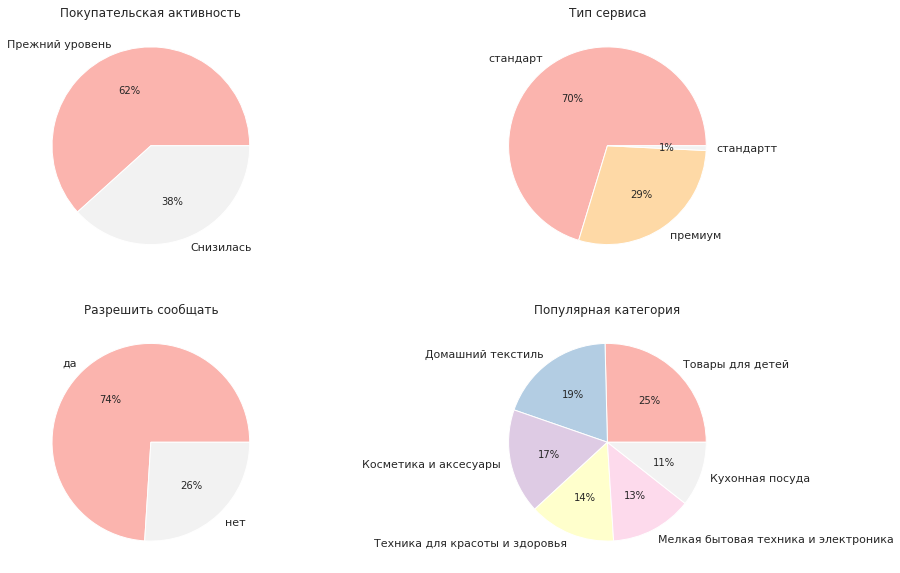

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()

object_columns = list(market_file.select_dtypes('object').columns)

for i, obj_col in enumerate(object_columns):
    (market_file[obj_col]
 .value_counts()
 .plot(
     kind='pie',
     autopct="%.0f%%",
     ylabel="",
     title=f"{obj_col.replace('_', ' ')}",
     colormap='Pastel1',
     ax=ax[i]
      ));

Видим неявный дубликат в столбце `Тип сервиса` - `стандартт`. Вероятнее всего, это просто опечатка. Заменим эти значения на `стандарт`

In [21]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace({
    'стандартт': 'стандарт'
})

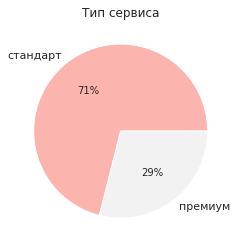

In [22]:
(market_file['Тип сервиса']
 .value_counts()
 .plot(
     kind='pie',
     autopct="%.0f%%",
     ylabel="",
     title=f"Тип сервиса",
     colormap='Pastel1'
      ));

In [23]:
market_file.columns = map(lambda x: x.replace('_', ' '), market_file.columns)

In [24]:
market_file.columns

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет актив 6 мес', 'Маркет актив тек мес', 'Длительность',
       'Акционные покупки', 'Популярная категория',
       'Средний просмотр категорий за визит',
       'Неоплаченные продукты штук квартал', 'Ошибка сервиса',
       'Страниц за визит'],
      dtype='object')

## Датасет `market_money.csv`

In [ ]:
try:
    market_money = pd.read_csv('/datasets/market_money.csv')
except:
    market_money = pd.read_csv('<Path>')

In [26]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [27]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


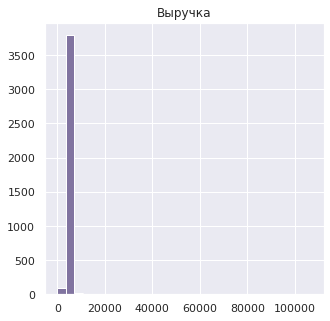

In [28]:
(market_money
 .drop(columns='id')
 .hist(
     figsize=(5, 5), 
     bins=30,
     color=DEFAULT_COLOR
 ));

Наблюдаются выбросы в правой части распределения

In [29]:
market_money[market_money['Выручка'] > 20000]

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


In [30]:
market_money.drop(index=98, inplace=True)

Вполне могло случится так, что в текущем месяце клиент купил что-то дорогое

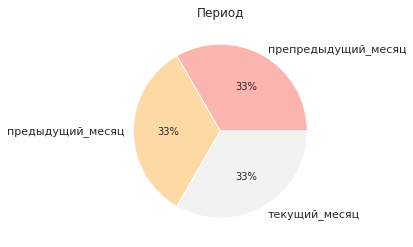

In [31]:
(market_money['Период']
 .value_counts()
 .plot(
     kind='pie',
     autopct="%.0f%%",
     ylabel="",
     title=f"Период",
     colormap='Pastel1'
      ));

In [32]:
market_money['Период'] = market_money['Период'].str.replace('_', ' ')

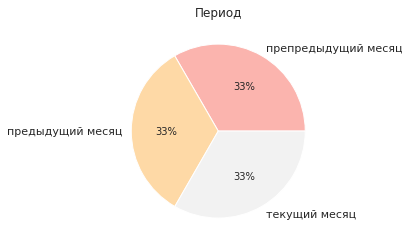

In [33]:
(market_money['Период']
 .value_counts()
 .plot(
     kind='pie',
     autopct="%.0f%%",
     ylabel="",
     title=f"Период",
     colormap='Pastel1'
      ));

### Исследование на пропуски

In [34]:
market_money.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

### Исследование на дубликаты

In [35]:
market_money.duplicated().sum()

np.int64(0)

подготовим сразу же данные для будущего соединения

In [36]:
market_money_modified = market_money.pivot_table(
    index='id',
    columns='Период',
    values='Выручка',
    aggfunc='sum'
)

In [37]:
market_money_modified.head()

Период,предыдущий месяц,препредыдущий месяц,текущий месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [38]:
market_money_modified.columns = market_money_modified.columns + ' (выручка)'

## Датасет `market_time.csv`


In [ ]:
try:
    market_time = pd.read_csv('/datasets/market_time.csv')
except:
    market_time = pd.read_csv('<PATH>')

In [40]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [41]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


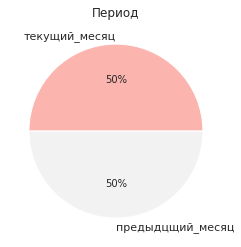

In [42]:
(market_time['Период']
 .value_counts()
 .plot(
     kind='pie',
     autopct="%.0f%%",
     ylabel="",
     title=f"Период",
     colormap='Pastel1'
      ));

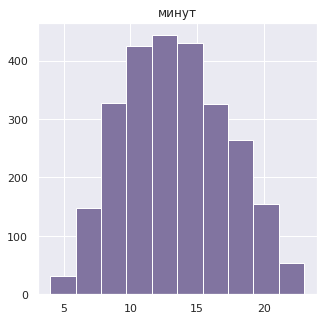

In [43]:
(market_time
 .drop(columns='id')
 .hist(
     figsize=(5, 5), 
     bins=10,
     color=DEFAULT_COLOR
 ));

### Исследование на пропуски

In [44]:
market_time.isna().sum()

id        0
Период    0
минут     0
dtype: int64

### Исследование на дубликаты

In [45]:
market_time.duplicated().sum()

np.int64(0)

In [46]:
market_time['Период'] = market_time['Период'].str.replace('_', ' ')

In [47]:
market_time['Период'] = market_time['Период'].replace({
    'предыдцщий месяц': 'предыдущий месяц'
})

In [48]:
market_time_modified = market_time.pivot_table(
    index='id',
    columns='Период',
    values='минут',
    aggfunc='sum'
)

In [49]:
market_time_modified.head()

Период,предыдущий месяц,текущий месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [50]:
market_time_modified.columns = market_time_modified.columns + ' (минуты)'

## Датасет `money.csv`


In [ ]:
try:
    money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
except:
    money = pd.read_csv('<PATH>', sep=';', decimal=',')

In [52]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [53]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


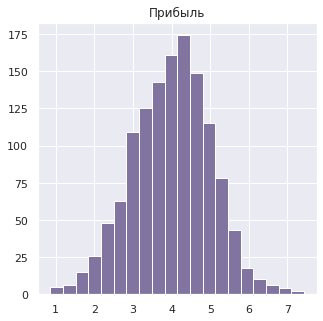

In [54]:
(money
 .drop(columns='id')
 .hist(
     figsize=(5, 5), 
     bins=20,
     color=DEFAULT_COLOR
 ));

Вывод по предобработке

- Пропусков в датасетах не нашлось
- Явные дубликаты не были найдены. Неявные дубликаты были выявлены в датасете `market_file` (столбец с типом сервиса)
- Кириллица в названиях столбцов была оставлена, однако нижнее подчеркивание из названий удалено
- В данных по выручке был найден один большой выброс
- Также были подготовлены сводные таблицы по каждому периоду для датасетов `market_time` и `market_money`

## Исследовательский анализ данных

### Датасет `market_file.csv`

#### Покупательская активность

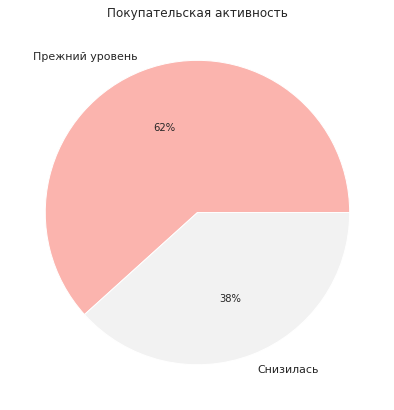

In [55]:
(market_file['Покупательская активность']
 .value_counts()
 .plot(
     kind='pie',
     autopct="%.0f%%",
     ylabel="",
     figsize=(7,7),
     title=f"Покупательская активность",
     colormap='Pastel1'));

Видим, что таргет несбалансирован. Перед применением моделей машинного обучения необходимо будет устранить влияние этого фактора

In [56]:
market_file_numerical_columns = market_file.drop(columns=['id']).select_dtypes(['float64', 'int', 'int64']).columns

piv = (market_file
 .pivot_table(
     index='Покупательская активность', 
     values=market_file_numerical_columns, 
     aggfunc='median'))

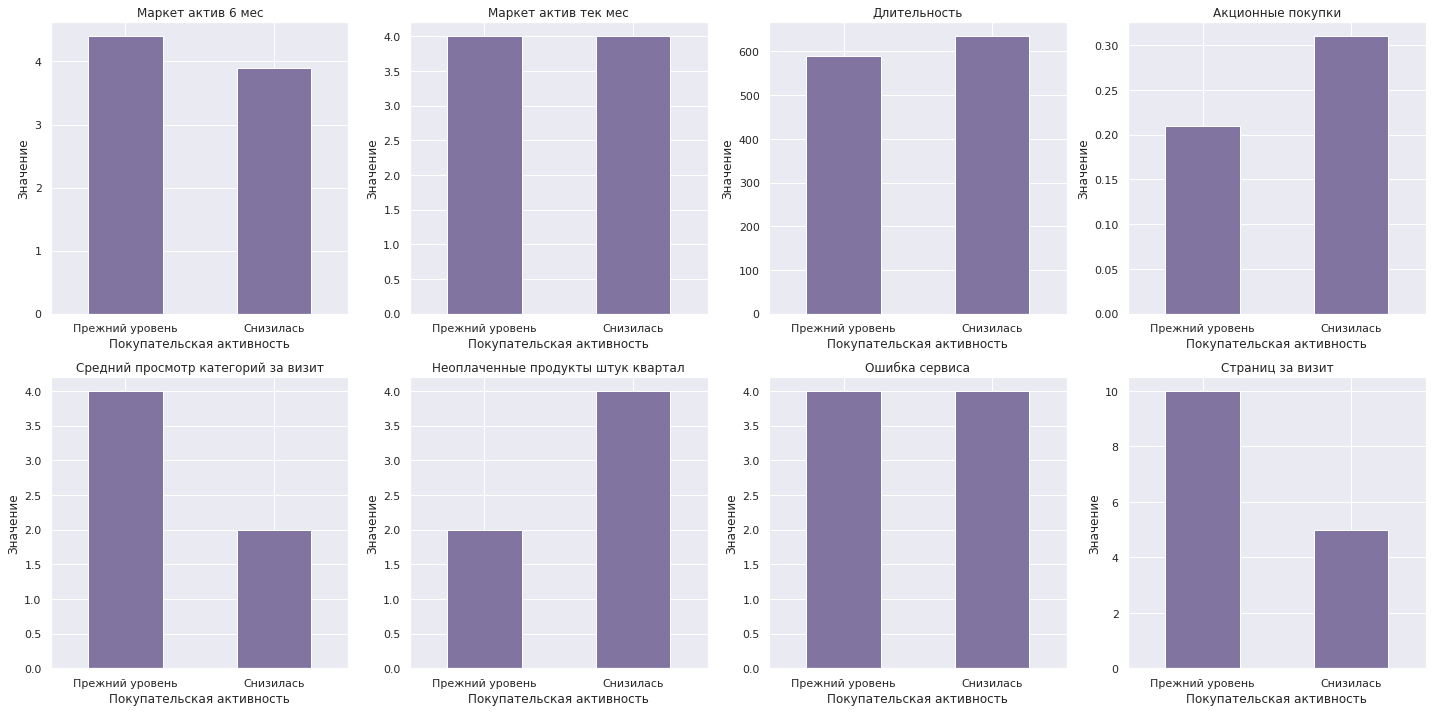

In [57]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax = ax.flatten()


for i, c in enumerate(market_file_numerical_columns):
    piv[[c]].plot(kind='bar', ax=ax[i], title=c, legend=False, ylabel='Значение', color=DEFAULT_COLOR)
    ax[i].tick_params(rotation=0) 
fig.tight_layout()

- Видим, что у клиентов со сниженным уровнем покупательской активности в среднем:
    - Меньше маркетинговых усилий за последние полгода
    - Больший процент акционных покупок
    - Меньше просмотренных категорий за визит
    - Больше неоплаченных продуктов за квартал
    - Меньше страниц за визит

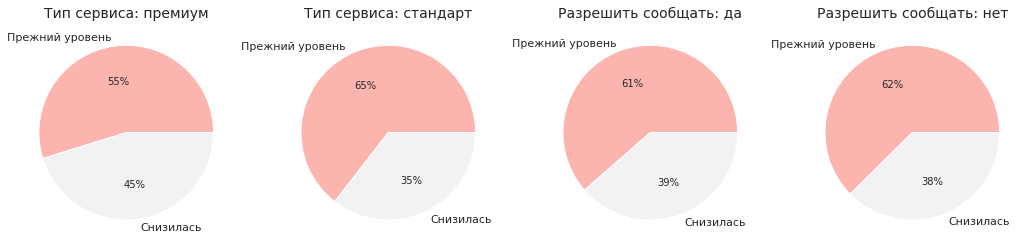

In [58]:
fig, ax = plt.subplots(1, 4, figsize=(18, 7))
ax = ax.flatten()

_ = (market_file
 .pivot_table(index='Покупательская активность', 
              columns='Тип сервиса', 
              values='id', 
              aggfunc='count')
 .reset_index()
 .set_index('Покупательская активность')
 .plot(kind='pie', 
       subplots=True, 
       legend=False,
       ax=ax[:2],
       figsize=(10, 5), 
       autopct="%.0f%%", 
       colormap='Pastel1'));


for a in _:
    a.set_title(f"Тип сервиса: {a.get_ylabel()}", fontsize=14)
    a.set_ylabel('')
    
    
_ = (market_file
 .pivot_table(index='Покупательская активность', 
              columns='Разрешить сообщать', 
              values='id', 
              aggfunc='count')
 .reset_index()
 .set_index('Покупательская активность')
 .plot(kind='pie', 
       subplots=True, 
       legend=False, 
       figsize=(10, 5),
       ax=ax[2:],
       autopct="%.0f%%", 
       colormap='Pastel1'));

for a in _:
    a.set_title(f"Разрешить сообщать: {a.get_ylabel()}", fontsize=14)
    a.set_ylabel('')

- В свою очередь от типа сервиса покупательская активность почти не зависит
- Еще меньшая зависимость от признака `Разрешить сообщать`

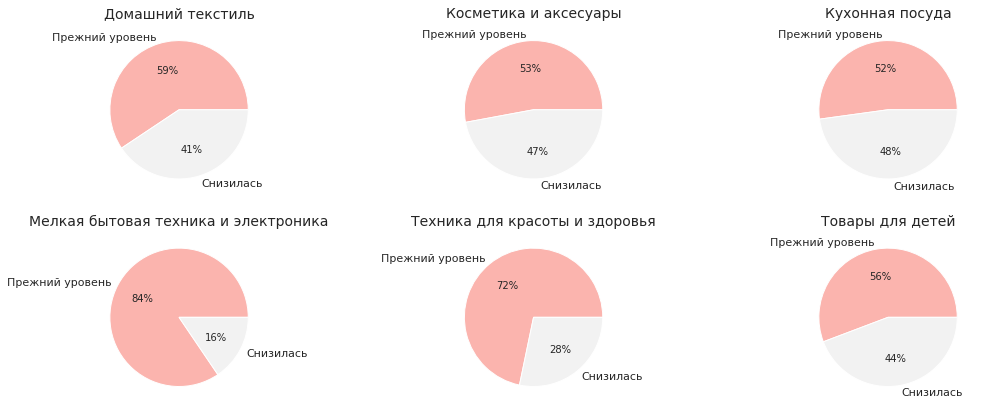

In [59]:
fig, ax = plt.subplots(2, 3, figsize=(18, 7))

ax = (market_file
 .pivot_table(index='Покупательская активность', 
              columns='Популярная категория', 
              values='id', 
              aggfunc='count')
 .reset_index()
 .set_index('Покупательская активность')
 .plot(kind='pie', 
       subplots=True, 
       legend=False, 
       autopct="%.0f%%",
       ax=ax,
       colormap='Pastel1'))


for a in ax:
    a.set_title(a.get_ylabel(), fontsize=14)
    a.set_ylabel('')

- Клиенты, у которых в столбце `популярная категорий` стоят `Мелкая бытовая техника и электроника` или `Техника для красоты и здоровья`, остались на том же уровне активности в большинстве своем

#### Тип сервиса

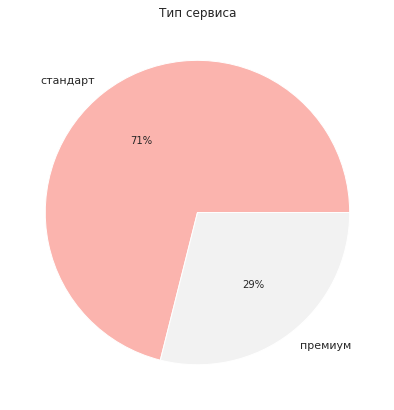

In [60]:
(market_file['Тип сервиса']
 .value_counts()
 .plot(
     kind='pie',
     autopct="%.0f%%",
     ylabel="",
     figsize=(7,7),
     title=f"Тип сервиса",
     colormap='Pastel1'));

- Большинство пользователей предпочитают стандартный тип сервиса

In [61]:
market_file_numerical_columns = market_file.drop(columns='id').select_dtypes(['float64', 'int', 'int64']).columns

piv = (market_file
 .pivot_table(
     index='Тип сервиса', 
     values=market_file_numerical_columns, 
     aggfunc='median'))

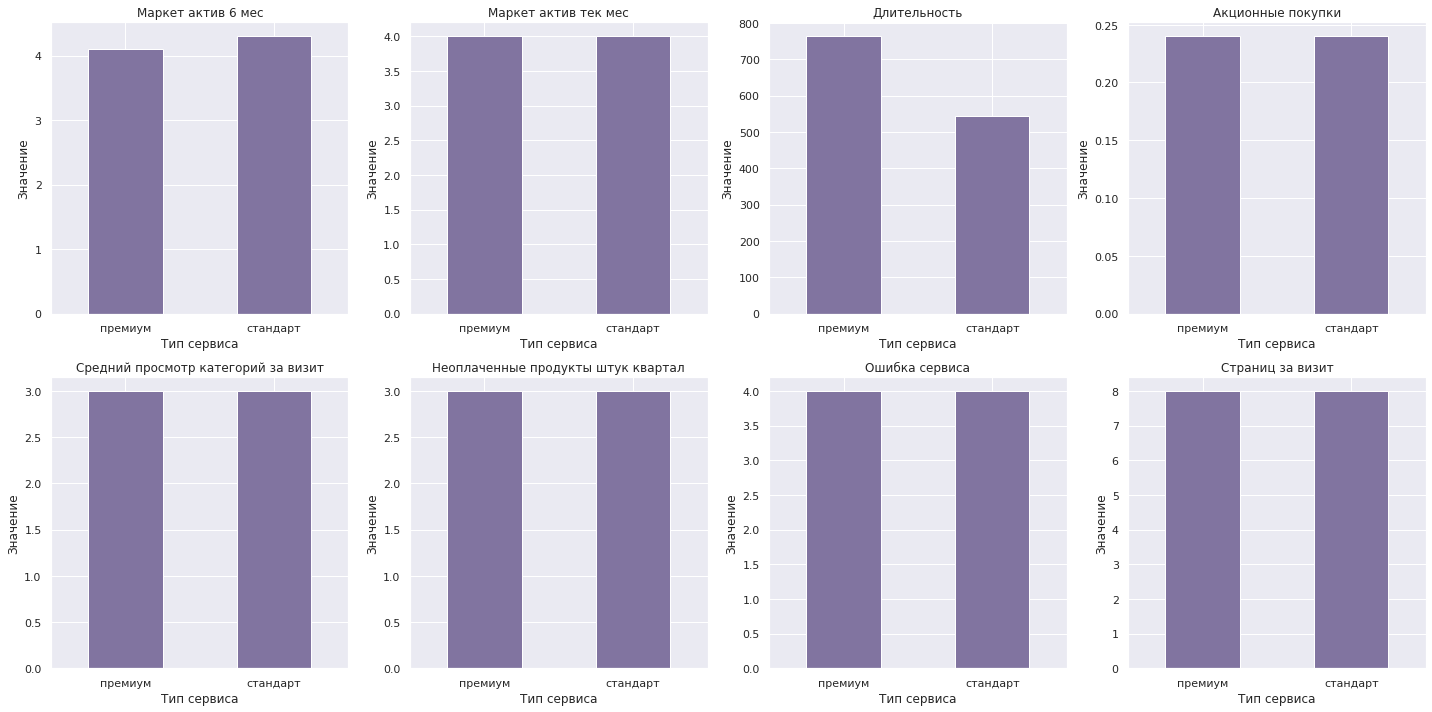

In [62]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax = ax.flatten()


for i, c in enumerate(market_file_numerical_columns):
    piv[[c]].plot(kind='bar', ax=ax[i], title=c, legend=False, ylabel='Значение', color=DEFAULT_COLOR)
    ax[i].tick_params(rotation=0)    
fig.tight_layout()

- Видим, что типичное значение длительности значительно отличается для клиентов, использующих разные типы сервиса. Возможно, клиенты, давно покупающие в интернет-магазине, доверяют ему и предпочитают более комфортный тип сервиса `Премиум`

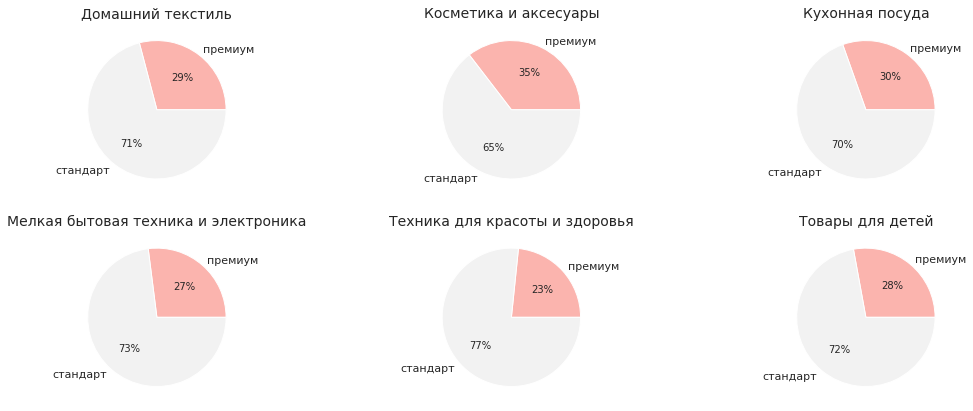

In [63]:
fig, ax = plt.subplots(2, 3, figsize=(18, 7))

ax = (market_file
 .pivot_table(index='Тип сервиса', 
              columns='Популярная категория', 
              values='id', 
              aggfunc='count')
 .reset_index()
 .set_index('Тип сервиса')
 .plot(kind='pie', 
       subplots=True, 
       legend=False, 
       autopct="%.0f%%",
       ax=ax,
       colormap='Pastel1'))


for a in ax:
    a.set_title(a.get_ylabel(), fontsize=14)
    a.set_ylabel('')

Видим, что практически никакой зависимости между популярной категорией и типом сервиса нет.

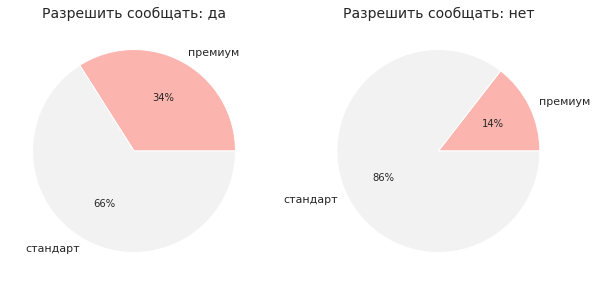

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))
ax = ax.flatten()

    
_ = (market_file
 .pivot_table(index='Тип сервиса', 
              columns='Разрешить сообщать', 
              values='id', 
              aggfunc='count')
 .reset_index()
 .set_index('Тип сервиса')
 .plot(kind='pie', 
       subplots=True, 
       legend=False, 
       figsize=(10, 5),
       ax=ax,
       autopct="%.0f%%", 
       colormap='Pastel1'
      ));

for a in _:
    a.set_title(f"Разрешить сообщать: {a.get_ylabel()}", fontsize=14)
    a.set_ylabel('')

- Чуть больше трети тех, кто разрешил рассылку, используют премиум сервис
- Менее 20 процентов людей, запретивших рассылку, используют премиум сервис

#### Разрешить сообщать

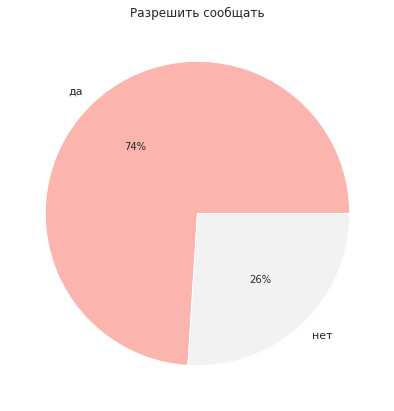

In [65]:
(market_file['Разрешить сообщать']
 .value_counts()
 .plot(
     kind='pie',
     autopct="%.0f%%",
     ylabel="",
     figsize=(7,7),
     title=f"Разрешить сообщать",
     colormap='Pastel1'));

- Почти 3/4 клиентов разрешили рассылку

In [66]:
market_file_numerical_columns = market_file.drop(columns='id').select_dtypes(['float64', 'int', 'int64']).columns

piv = (market_file
 .pivot_table(
     index='Разрешить сообщать', 
     values=market_file_numerical_columns, 
     aggfunc='median'))

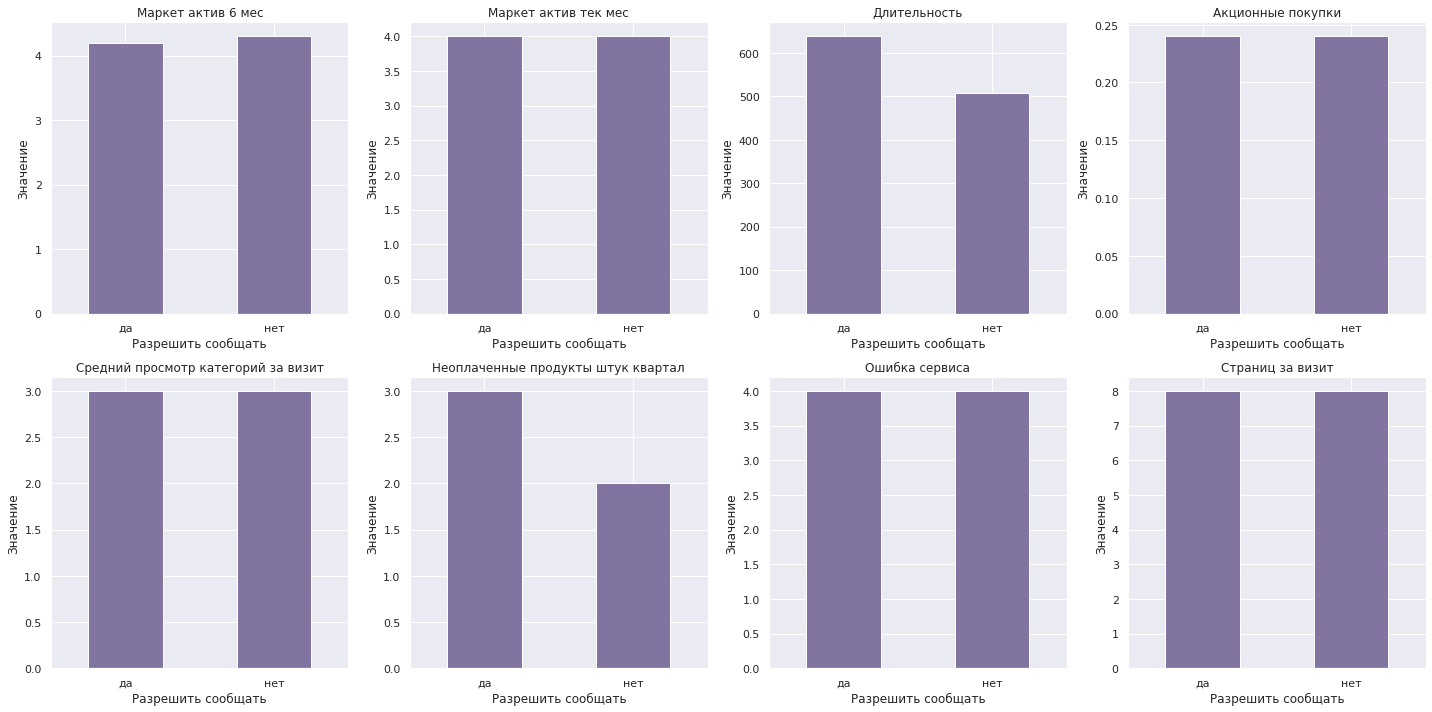

In [67]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax = ax.flatten()


for i, c in enumerate(market_file_numerical_columns):
    piv[[c]].plot(kind='bar', ax=ax[i], title=c, legend=False, ylabel='Значение', color=DEFAULT_COLOR)
    ax[i].tick_params(rotation=0)   
fig.tight_layout()

- Разрешившие рассылку клиенты в среднем стали клиентами раньше
- Есть небольшая разница в количестве неоплаченных продуктов за квартал среди тех, кто разрешил и запретил рассылку

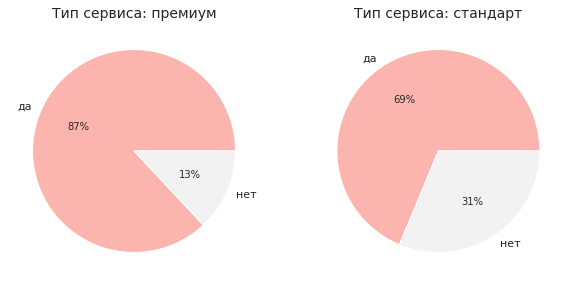

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))
ax = ax.flatten()

    
_ = (market_file
 .pivot_table(index='Разрешить сообщать', 
              columns='Тип сервиса', 
              values='id', 
              aggfunc='count')
 .reset_index()
 .set_index('Разрешить сообщать')
 .plot(kind='pie', 
       subplots=True, 
       legend=False, 
       figsize=(10, 5),
       ax=ax,
       autopct="%.0f%%", 
       colormap='Pastel1'));

for a in _:
    a.set_title(f"Тип сервиса: {a.get_ylabel()}", fontsize=14)
    a.set_ylabel('')

- Большинство клиентов с премиальным сервисом разрешили рассылку
- Около трети клиентов со стандартным сервисом запретили рассылку

#### Популярная категория

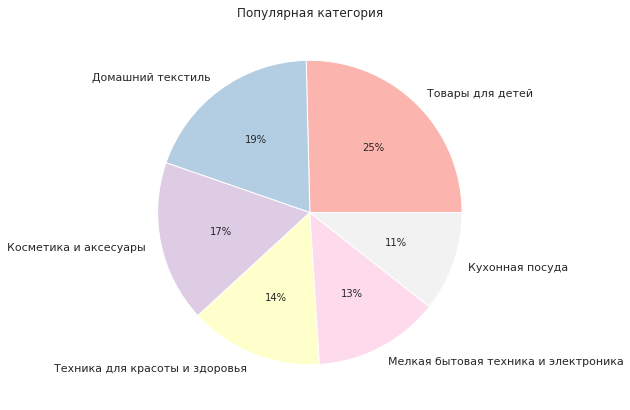

In [69]:
(market_file['Популярная категория']
 .value_counts()
 .plot(
     kind='pie',
     autopct="%.0f%%",
     ylabel="",
     figsize=(7,7),
     title=f"Популярная категория",
     colormap='Pastel1'));

- Самая популярная категорий товаров - `Товары для детей`
- Наименее популярна категория - `Кухонная посуда`

#### Маркетинговая активность за 6 месяцев (Маркет актив 6 мес)

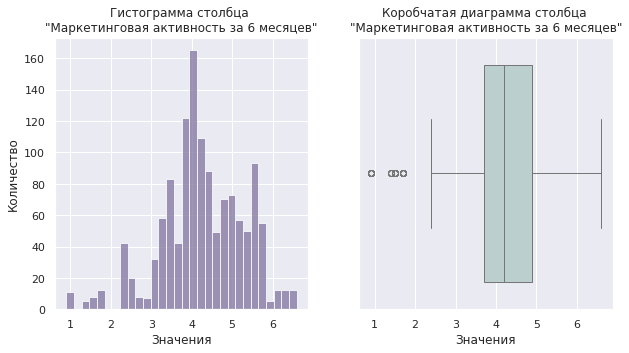

In [70]:
plot_graphics(market_file, 
              'Маркет актив 6 мес', 
              col_alias='\n"Маркетинговая активность за 6 месяцев"', 
              hist_color=DEFAULT_COLOR)

Наблюдается небольшое количество выбросов слева от основной части распределения

In [71]:
low_activity = market_file.loc[market_file['Маркет актив 6 мес'] < 2]

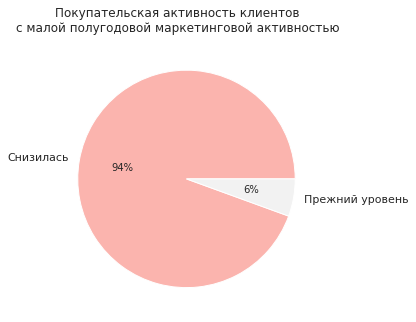

In [72]:
(low_activity['Покупательская активность']
 .value_counts()
 .plot(kind='pie', 
       subplots=True, 
       legend=False, 
       figsize=(10, 5),
       autopct="%.0f%%", 
       ylabel='',
       title='Покупательская активность клиентов\nс малой полугодовой маркетинговой активностью',
       colormap='Pastel1'));

- Практически все те, на кого были потрачены малые маркетинговые усилия за последние полгода, стали покупать меньше

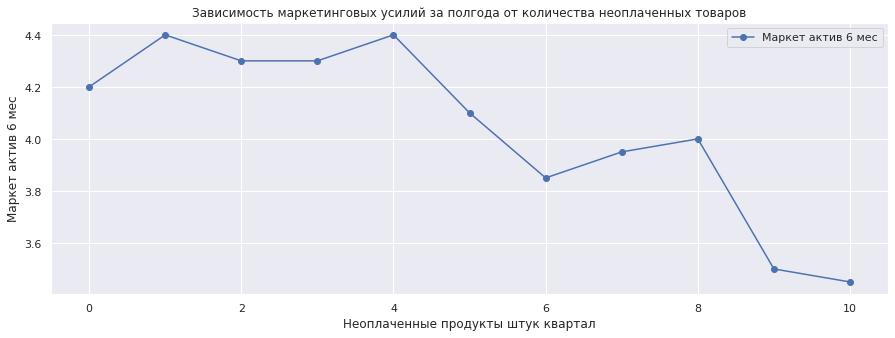

In [73]:
(market_file
 .pivot_table(
     index='Неоплаченные продукты штук квартал', 
     values='Маркет актив 6 мес', 
     aggfunc='median')
 .plot(figsize=(15, 5), 
       marker='o', 
       ylabel='Маркет актив 6 мес', 
       title='Зависимость маркетинговых усилий за полгода от количества неоплаченных товаров'));

- Кроме того, маркетинговая активность влияет и на количество неоплаченных продуктов. Чем больше таких продуктов, тем меньше маркетинговая активность была определена таким клиентам

#### Маркетинговая активность в текущем месяце (Маркет актив тек мес)

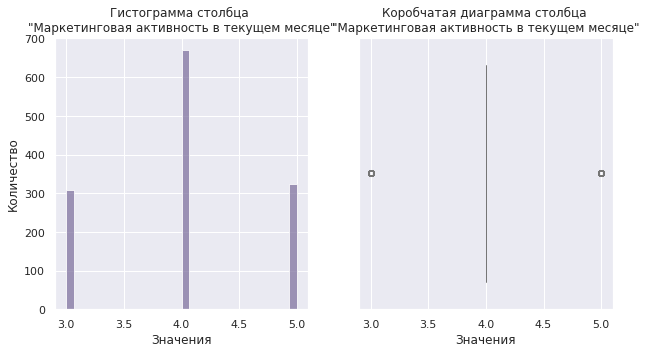

In [74]:
plot_graphics(market_file, 
              'Маркет актив тек мес', 
              col_alias='\n"Маркетинговая активность в текущем месяце"', 
              hist_color=DEFAULT_COLOR)

Признак выглядит дискретно. Его множество значений состоит из трех значений. Самое частое значение - 4

#### Длительность

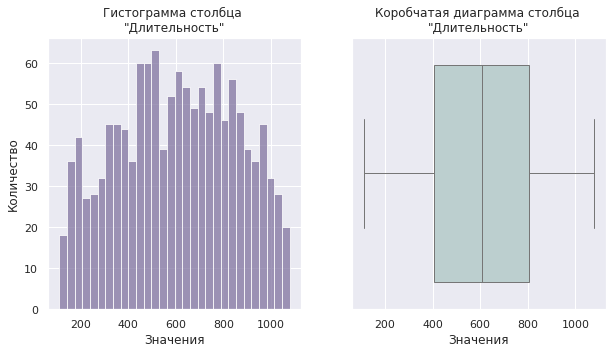

In [75]:
plot_graphics(market_file, 
              'Длительность', 
              col_alias='\n"Длительность"', 
              hist_color=DEFAULT_COLOR)


- Гистограмма длительности выглядит образцово-показательно. Выбросов не наблюдается

In [76]:
market_file['Длительность'].describe()

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: Длительность, dtype: float64

- Среднее значение признака колеблется около 600 дней

#### Акционные покупки

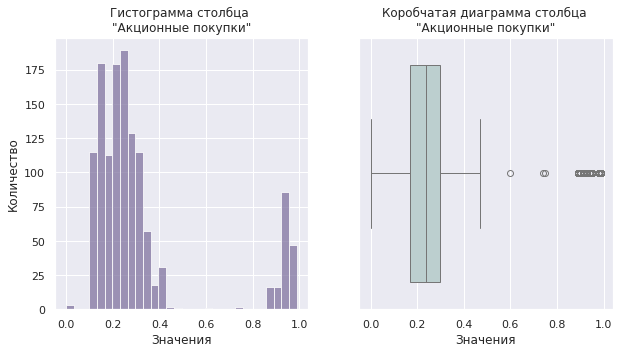

In [77]:
plot_graphics(market_file, 
              'Акционные покупки', 
              col_alias='\n"Акционные покупки"', 
              hist_color=DEFAULT_COLOR)


In [78]:
market_file[(market_file['Акционные покупки'] < 0.1)]

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет актив 6 мес,Маркет актив тек мес,Длительность,Акционные покупки,Популярная категория,Средний просмотр категорий за визит,Неоплаченные продукты штук квартал,Ошибка сервиса,Страниц за визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
9,215357,Снизилась,стандарт,да,3.9,5,154,0.0,Техника для красоты и здоровья,3,3,9,5
11,215359,Снизилась,стандарт,да,4.6,5,110,0.0,Домашний текстиль,4,2,4,2


In [79]:
market_file[(market_file['Акционные покупки'] > 0.5) & (market_file['Акционные покупки'] < 0.7)]

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет актив 6 мес,Маркет актив тек мес,Длительность,Акционные покупки,Популярная категория,Средний просмотр категорий за визит,Неоплаченные продукты штук квартал,Ошибка сервиса,Страниц за визит
417,215765,Прежний уровень,стандарт,нет,3.9,4,388,0.6,Косметика и аксесуары,4,0,4,8


- Видим небольшой пик в районе нуля и значительный пробел с одним объектом в районе от 0.5 до 0.7

In [80]:
def sale_purchase_grouper(x):
    if x < 0.6:
        return 'умеренно'
    return 'много'

In [81]:
market_file['группа акционных покупок'] = market_file['Акционные покупки'].apply(sale_purchase_grouper)

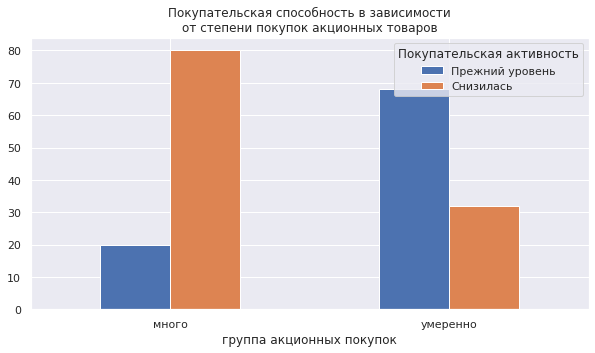

In [82]:
piv = market_file.pivot_table(index='Покупательская активность', columns='группа акционных покупок', values='id', aggfunc='count')
ax = (((piv / piv.sum(axis=0))
 .fillna(0)
 .round(2) * 100)
      .T
      .plot(kind='bar', 
            figsize=(10,5), 
            title='Покупательская способность в зависимости\nот степени покупок акционных товаров')
      .tick_params(rotation=0))

- Среди клиентов с малым уровнем акционных покупок (менее 10 процентов) наблюдается только снижение покупательской активности. Хотя судить об этой группе нет большого смысла, там всего три клиента
- А вот в остальных группах наблюдается совершенно противоположные ситуации
    - В группе умеренных акционных покупок большинство клиентов остались на прежнем уровне покупательской активности
    - В группе высоких акционных покупок видна обратная ситуация: большинство клиентов снизили свою активность 
    
Последний довод возможно связан с тем, что в какой-то месяц проводилась большая акция, а далее цены вернулись в исходное состояние

#### Неоплаченные продукты

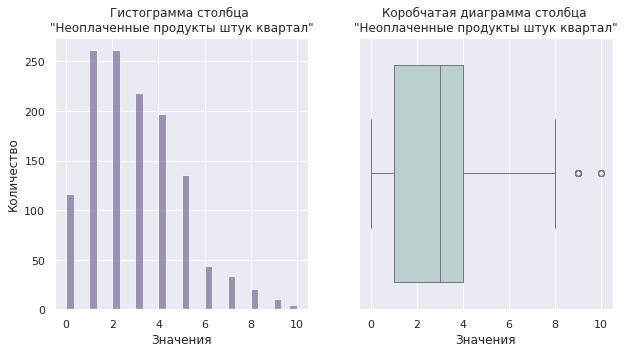

In [83]:
plot_graphics(market_file, 
              'Неоплаченные продукты штук квартал', 
              col_alias='\n"Неоплаченные продукты штук квартал"', 
              hist_color=DEFAULT_COLOR)


- Видим, что в среднем неоплаченными остаются около 1-4 товаров

In [84]:
market_file['неоплаченные категория'] = market_file['Неоплаченные продукты штук квартал'].apply(lambda x: 'мало' if x < 6 else 'много')

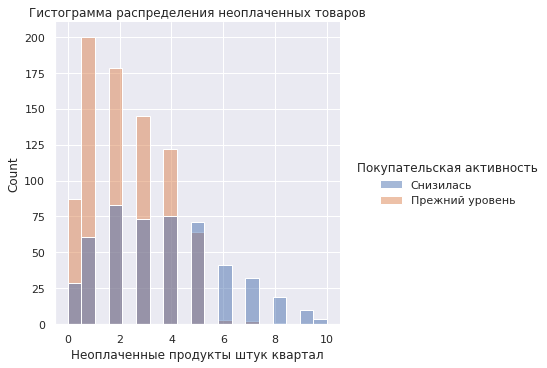

In [85]:
(sns.displot(
    data=market_file, 
    x='Неоплаченные продукты штук квартал', 
    hue='Покупательская активность', 
    kind='hist')
 .set(title='Гистограмма распределения неоплаченных товаров'));

- Подкрасив гистогграмму значением целевого признака, можно отметить, что при 6 и более неоплаченных товарах в основном покупательская активность клиентов снижается. Есть смысл ввести дополнительный категориальный признак

#### Cредний просмотр категорий

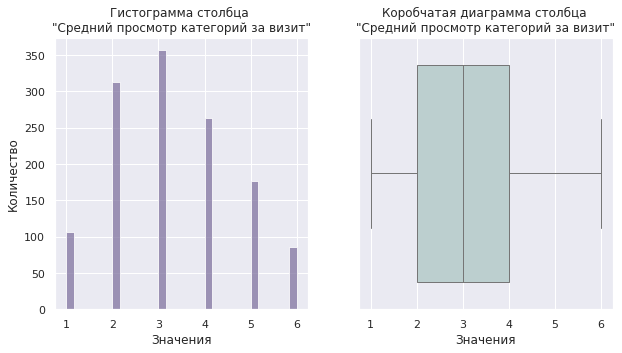

In [86]:
plot_graphics(market_file, 
              'Средний просмотр категорий за визит', 
              col_alias='\n"Средний просмотр категорий за визит"', 
              hist_color=DEFAULT_COLOR)


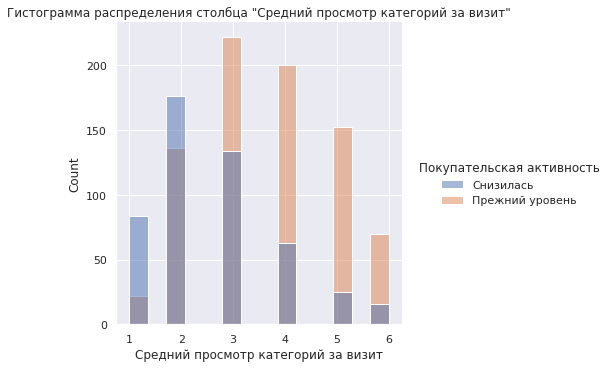

In [87]:
(sns.displot(
    data=market_file, 
    x='Средний просмотр категорий за визит', 
    hue='Покупательская активность', 
    kind='hist')
 .set(title='Гистограмма распределения столбца "Средний просмотр категорий за визит"'));

Признак дискретный. Видно, что при увеличении числа категорий растет число клиентов, оставшихся на прежнем уровне

#### Страниц за визит

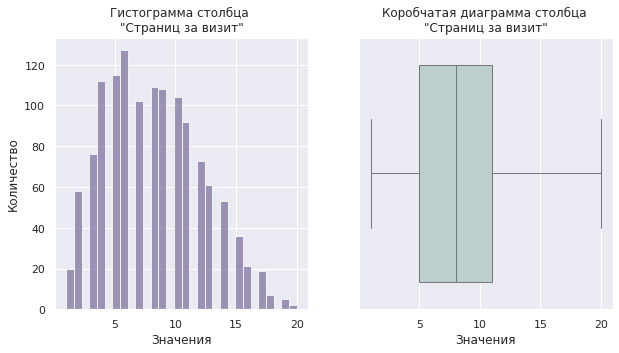

In [88]:
plot_graphics(market_file, 
              'Страниц за визит', 
              col_alias='\n"Страниц за визит"', 
              hist_color=DEFAULT_COLOR)

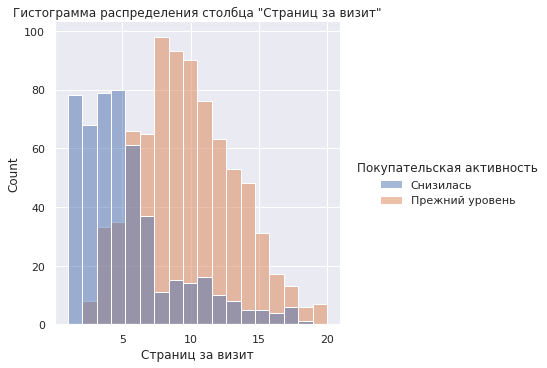

In [89]:
(sns.displot(
    data=market_file, 
    x='Страниц за визит', 
    hue='Покупательская активность', 
    kind='hist')
 .set(title='Гистограмма распределения столбца "Страниц за визит"'));

- Можно отметить, что при росте числа страниц за визит растет число клиентов, оставшихся на прежнем уровне активности

#### Ошибка сервиса

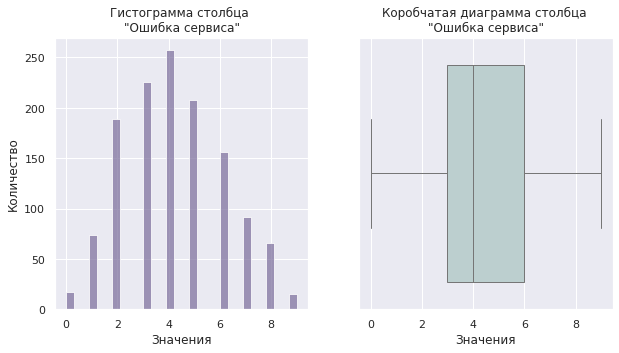

In [90]:
plot_graphics(market_file, 
              'Ошибка сервиса', 
              col_alias='\n"Ошибка сервиса"', 
              hist_color=DEFAULT_COLOR)

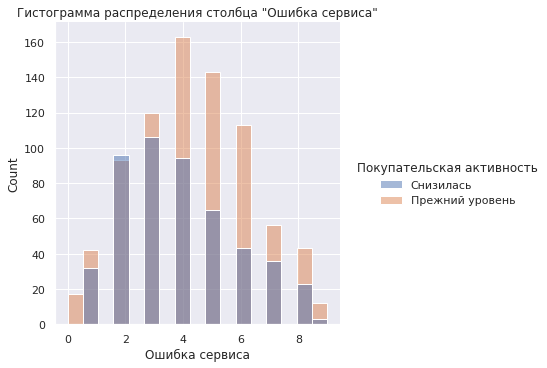

In [91]:
(sns.displot(
    data=market_file, 
    x='Ошибка сервиса', 
    hue='Покупательская активность', 
    kind='hist')
 .set(title='Гистограмма распределения столбца "Ошибка сервиса"'));

Итак, согласно по результатам исследования данного датасета можно заключить следующее:

- Наблюдается дисбаланс целевого признака
- Снижение покупательской активности наблюдается у клиентов, для которых характерны:
    - Меньше маркетинговых усилий за последние полгода
    - Больший процент акционных покупок
    - Меньше просмотренных категорий за визит
    - Больше неоплаченных продуктов за квартал
    - Меньше страниц за визит


- В свою очередь от типа сервиса покупательская активность в среднем почти не зависит
- Еще меньшая зависимость от признака `Разрешить сообщать`
- Клиенты, у которых в столбце `популярная категорий` стоят `Мелкая бытовая техника и электроника` или `Техника для красоты и здоровья`, остались на том же уровне активности в большинстве своем
- Большинство пользователей предпочитают стандартный тип сервиса
- Типичное значение длительности значительно отличается для клиентов, использующих разные типы сервиса. Возможно, клиенты, давно покупающие в интернет-магазине, доверяют ему и предпочитают более комфортный тип сервиса `Премиум`
- Между популярной категорией и типом сервиса не наблюдается никакой взаимосвязи. В каждой категории значительно преобладает стандартный тип сервиса
- При этом большинство клиентов с премиальным сервисом разрешили рассылку
- Около трети клиентов со стандартным сервисом запретили рассылку
- Кроме того, премиальный сервис предпочитают старые клиенты
- Самая популярная категорий товаров - `Товары для детей`
- Наименее популярна категория - `Кухонная посуда`
- Практически все те, на кого были потрачены малые маркетинговые усилия за последние полгода, стали покупать меньше
- Среди клиентов с малым уровнем акционных покупок (менее 10 процентов) наблюдается только снижение покупательской активности. Хотя судить об этой группе нет большого смысла, там всего три клиента
- А вот в остальных группах наблюдается совершенно противоположные ситуации
    - В группе умеренных акционных покупок большинство клиентов остались на прежнем уровне покупательской активности
    - В группе высоких акционных покупок видна обратная ситуация: большинство клиентов снизили свою активность 
  
Последний довод возможно связан с тем, что в какой-то месяц проводилась большая акция, а далее цены вернулись в исходное состояние

- Было обнаружено, что при 6 и более неоплаченных продуктов у клиентов в основном наблюдается снижение покупательской активности
- При увеличении числа категорий и числа страниц за визит растет число клиентов, оставшихся на прежнем уровне покупательской активности

### Датасет `market_money.csv`

#### Выручка

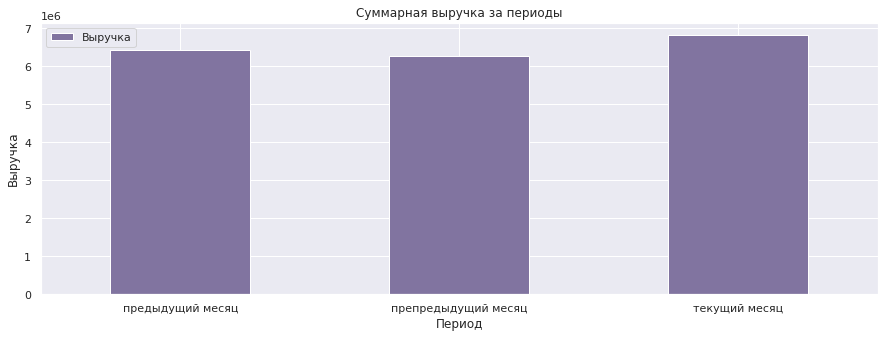

In [92]:
ax = (market_money
 .pivot_table(
     index='Период', 
     values='Выручка', 
     aggfunc='sum')
 .plot(figsize=(15, 5), 
       title='Суммарная выручка за периоды', 
       ylabel='Выручка', 
       kind='bar', color=DEFAULT_COLOR));

ax.tick_params(rotation=0)

- Видно, что выручка растет, в текущий месяц она имеет максимальное значение
- Сделаем отбор клиентов, которые были активны в последние три месяца

In [93]:
market_money_modified['is_active'] = market_money_modified.apply(lambda x: (x.iloc[0] > 0) and (x.iloc[1] > 0) and (x.iloc[2] > 0), axis=1).astype(int)

In [94]:
active_users_ids = list(market_money_modified.query('is_active == 1').index)

### Датасет `market_time.csv`

#### Минут

In [95]:
market_time

,id,Период,минут
0,215348,текущий месяц,14
1,215348,предыдущий месяц,13
2,215349,текущий месяц,10
3,215349,предыдущий месяц,12
4,215350,текущий месяц,13
...,...,...,...
2595,216645,текущий месяц,18
2596,216646,предыдущий месяц,18
2597,216646,текущий месяц,7
2598,216647,текущий месяц,10


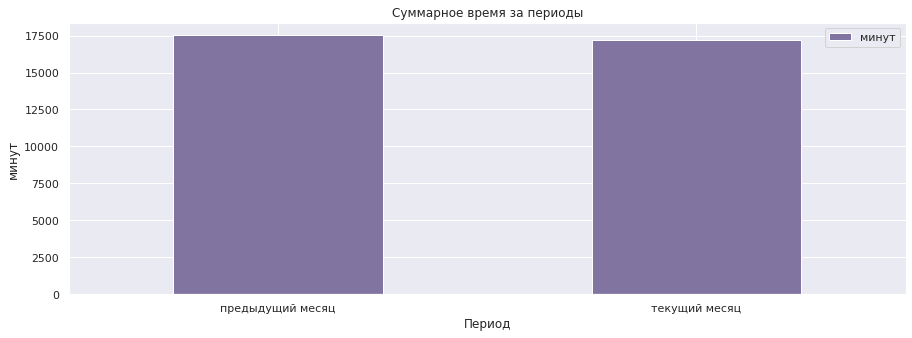

In [96]:
ax = (market_time
 .pivot_table(
     index='Период', 
     values='минут', 
     aggfunc='sum')
 .plot(
     figsize=(15, 5), 
     title='Суммарное время за периоды', 
     ylabel='минут', 
     kind='bar', 
     color=DEFAULT_COLOR));

ax.tick_params(rotation=0)

Суммарное проведенное время немного упало в сравнении с предыдущим месяцем

## Объединение данных

In [97]:
market_file_active = market_file[market_file.id.isin(active_users_ids)]

In [98]:
market_time_modified = market_time_modified[market_time_modified.index.isin(active_users_ids)]

In [99]:
market_money_modified = market_money_modified[market_money_modified.index.isin(active_users_ids)]

In [100]:
full_df = market_file_active.set_index('id').join([market_time_modified, market_money_modified], how='inner')

In [101]:
full_df.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет актив 6 мес,Маркет актив тек мес,Длительность,Акционные покупки,Популярная категория,Средний просмотр категорий за визит,Неоплаченные продукты штук квартал,Ошибка сервиса,Страниц за визит,группа акционных покупок,неоплаченные категория,предыдущий месяц (минуты),текущий месяц (минуты),предыдущий месяц (выручка),препредыдущий месяц (выручка),текущий месяц (выручка),is_active
id,,,,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,много,мало,12,10,5216.0,4472.0,4971.6,1
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,умеренно,мало,8,13,5457.5,4826.0,5058.4,1
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,много,мало,11,13,6158.0,4793.0,6610.4,1
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,много,мало,8,11,5807.5,4594.0,5872.5,1
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,умеренно,мало,10,10,4738.5,5124.0,5388.5,1


In [102]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 215349 to 216647
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1296 non-null   object 
 1   Тип сервиса                          1296 non-null   object 
 2   Разрешить сообщать                   1296 non-null   object 
 3   Маркет актив 6 мес                   1296 non-null   float64
 4   Маркет актив тек мес                 1296 non-null   int64  
 5   Длительность                         1296 non-null   int64  
 6   Акционные покупки                    1296 non-null   float64
 7   Популярная категория                 1296 non-null   object 
 8   Средний просмотр категорий за визит  1296 non-null   int64  
 9   Неоплаченные продукты штук квартал   1296 non-null   int64  
 10  Ошибка сервиса                       1296 non-null   int64  
 11  Страниц за визит            

In [103]:
full_df.drop(columns='is_active', inplace=True)

Вывод по EDA:
    
- Был проведен детальный анализ трех датасетов
- Добавлен новый категориальныц признак на основе признака `Неоплаченные продукты штук квартал`
- Была проведена фильтрация активных пользователей
- Объединены три датасета

## Корреляционный анализ

interval columns not set, guessing: ['Маркет актив 6 мес', 'Маркет актив тек мес', 'Длительность', 'Акционные покупки', 'Средний просмотр категорий за визит', 'Неоплаченные продукты штук квартал', 'Ошибка сервиса', 'Страниц за визит', 'предыдущий месяц (минуты)', 'текущий месяц (минуты)', 'предыдущий месяц (выручка)', 'препредыдущий месяц (выручка)', 'текущий месяц (выручка)']


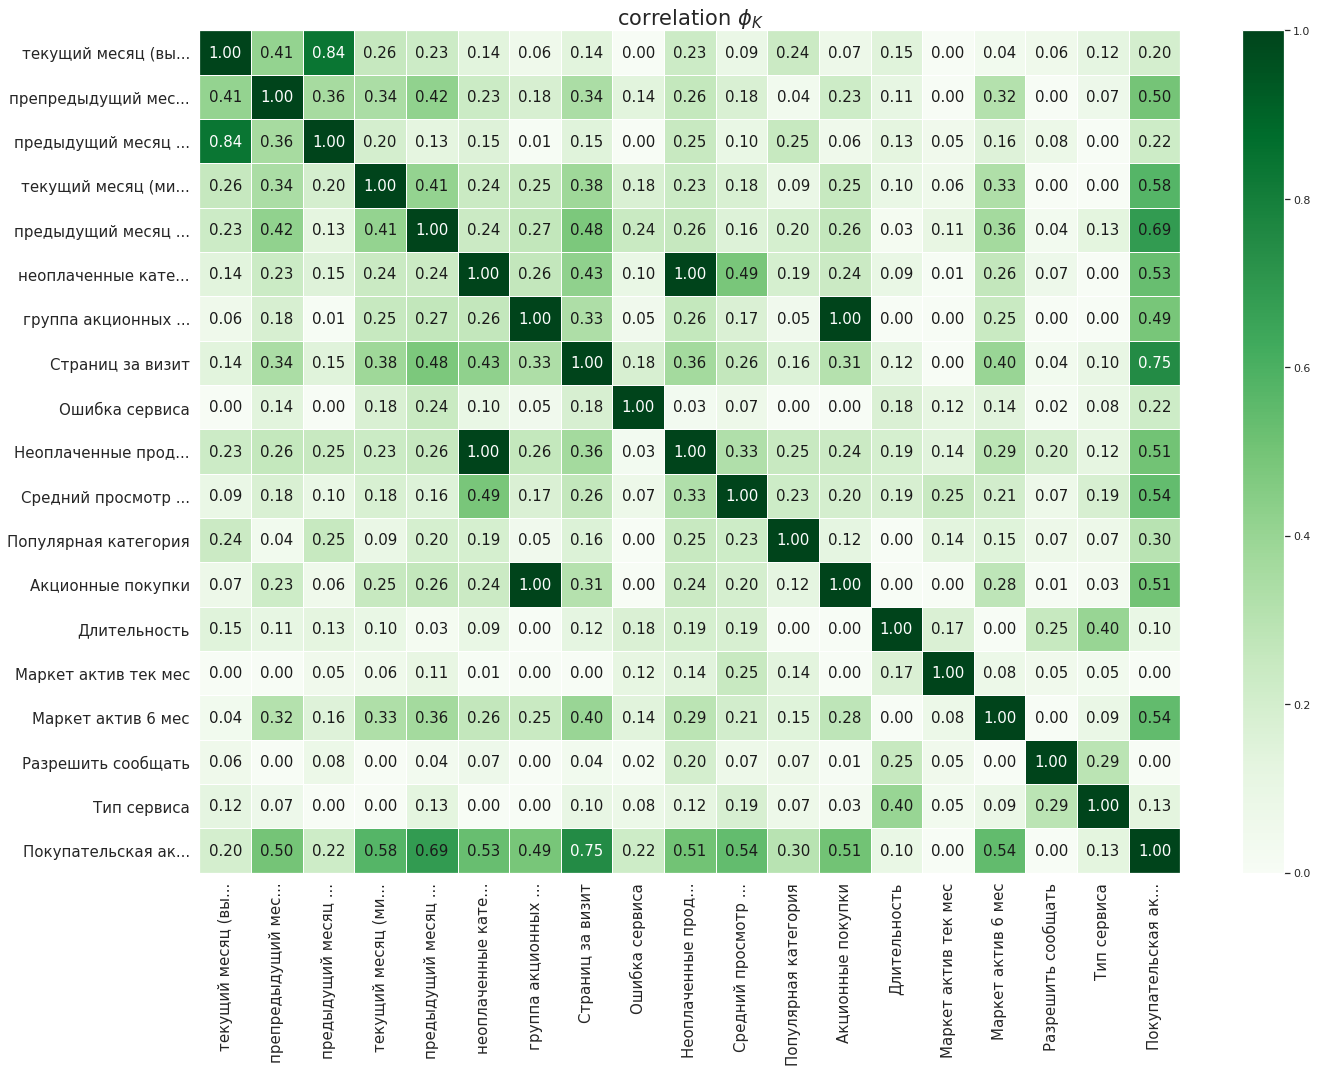

In [104]:
phik_overview = full_df.phik_matrix()
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

In [105]:
corr = full_df.phik_matrix(njobs=1).loc[:, ['Покупательская активность']].sort_values('Покупательская активность')[:-1]
corr

interval columns not set, guessing: ['Маркет актив 6 мес', 'Маркет актив тек мес', 'Длительность', 'Акционные покупки', 'Средний просмотр категорий за визит', 'Неоплаченные продукты штук квартал', 'Ошибка сервиса', 'Страниц за визит', 'предыдущий месяц (минуты)', 'текущий месяц (минуты)', 'предыдущий месяц (выручка)', 'препредыдущий месяц (выручка)', 'текущий месяц (выручка)']


,Покупательская активность
Разрешить сообщать,0.000000
Маркет актив тек мес,0.000000
Длительность,0.099901
Тип сервиса,0.129940
текущий месяц (выручка),0.197213
Ошибка сервиса,0.224154
предыдущий месяц (выручка),0.224638
Популярная категория,0.299717
группа акционных покупок,0.489158
препредыдущий месяц (выручка),0.497393


- Видно, что есть признаки, которые никак не влияют на целевой: `текущий месяц (выручка)`,  `Разрешить сообщать`, `Маркет актив тек мес`
- Кроме того, признаки, связанные с текущим месяцем `текущий месяц (минуты)` и `текущий месяц (выручка)` использовать для обучения моделей не следует. Это приводит к утечке целевого признака. Так как необходимо предсказать покупательскую активность клиентов в следующие три месяца, текущий месяц нельзя использовать до его окончания. В дальнейшем у модели не будет такой информации
- Удалим также и признаки `Неоплаченные продукты штук квартал` и `группа акционных покупок`, так как они имеют сильную корреляцию с признакми-дублерами с измененным типом данных. Причем признаки-дублеры имеют большее влияние на целевой признак, чем удаляемые

In [106]:
low_corr_cols = list(corr[corr['Покупательская активность'] < .12].index)

In [107]:
temp = (full_df
        .drop(columns=['is_active', 'Акционные покупки'], errors='ignore')
        .replace({'неоплаченные категория': 
                  {
                        'мало': 0,
                        'много': 1
                  }
                 })).copy()

temp['группа акционных покупок'] = (temp['группа акционных покупок'] == 'много').astype(int)
temp[['неоплаченные категория']] = temp[['неоплаченные категория']].astype(int)


market_file_numerical_columns = (temp
                                 .select_dtypes(['float64', 'int', 'int64'])
                                 .columns)

df = pd.DataFrame(temp[market_file_numerical_columns], 
                  columns=market_file_numerical_columns)

X = add_constant(df)

vif = pd.DataFrame(
    {
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    }
)
vif

/tmp/ipykernel_182/2630599976.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = (full_df


,Variable,VIF
0,const,343.280578
1,Маркет актив 6 мес,1.217779
2,Маркет актив тек мес,1.045618
3,Длительность,1.100791
4,Средний просмотр категорий за визит,1.189036
5,Неоплаченные продукты штук квартал,1.919410
6,Ошибка сервиса,1.079602
7,Страниц за визит,1.452977
8,группа акционных покупок,1.106067
9,неоплаченные категория,1.906128


Мультиколлинеарность не наблюдается

- Удалили признаки, не влияющие на таргет
- Устранили утечку данных
- Удалили признаки-дублеры

## Обучение модели

Проблема дисбаланса классов никуда не исчезла. Для нивелирования ее воздействия на процесс обучения модели будем использовать параметр ```class_weight='balanced'```

In [210]:
full_df = full_df.drop(columns=[
    'is_active', 
    *low_corr_cols, 
    'текущий месяц (минуты)', 
    'текущий месяц (выручка)', 
    'группа акционных покупок',
    'Неоплаченные продукты штук квартал',
    'Тип сервиса',
], errors='ignore')

In [211]:
X_train, X_test, y_train, y_test = train_test_split(
    full_df.drop(['Покупательская активность'], axis=1),
    full_df['Покупательская активность'],
    # test_size = TEST_SIZE,
    test_size = .3, 
    
    random_state = RANDOM_STATE,
    stratify = full_df['Покупательская активность'])

In [212]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [213]:
ohe_columns = ['Популярная категория']
ord_columns = ['неоплаченные категория']
num_columns = full_df.drop(columns='Покупательская активность').select_dtypes(['float64', 'int', 'int64']).columns

In [214]:
num_columns

Index(['Маркет актив 6 мес', 'Акционные покупки',
       'Средний просмотр категорий за визит', 'Ошибка сервиса',
       'Страниц за визит', 'предыдущий месяц (минуты)',
       'предыдущий месяц (выручка)', 'препредыдущий месяц (выручка)'],
      dtype='object')

In [215]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

In [216]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['мало', 'много'], 
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [217]:
data_preprocessor = ColumnTransformer(
    [
     ('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns),  
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])


Итак, была выбрана метрика F1 для оценки качества модели на кросс-валидации, потому что наблюдается явный дисбаланс классов. Предпочтение какому-либо классу не отдается, поэтому важно минимизировать ка кошибки I рода, так и II рода

In [218]:
param_grid_tree = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        
        'models__max_depth': range(2, 6, 1),
        'models__max_features': range(2, 12, 1),
        'models__min_samples_leaf': range(1, 10, 1),
        'models__min_samples_split': range(2, 10, 1),
        'preprocessor__num': ['passthrough', StandardScaler(), MinMaxScaler()]  
    }
]

randomized_search_tree = RandomizedSearchCV(
    pipe_final, 
    param_grid_tree, 
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise',
    n_iter=500
)

randomized_search_tree.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['Популярная '
                                                                                'категория']),
                                                                              ('ord',
                                                                               Pipelin...
                   n_iter=500, n_jobs=-1,
                   param_distributions=[{'models': [DecisionTreeClassifier(class_weight='balanced',
                                                                           random_state=42)],
                                         'models__max_depth': range(2, 6),
                                         'models__max_features': range(2, 12),
                                         'models__min_samples_leaf': range(1, 10),
                                         'models__min_samples_split': range(2, 10),
                                         'preprocessor__num': ['passthrough',
                                                               StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='f1')

In [220]:
print(randomized_search_tree.best_score_.round(3))

0.785


In [221]:
param_grid_logreg = [
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='saga', 
            class_weight='balanced',
            max_iter=3000,
        )],
        
        'models__C': np.arange(0.01, 0.2, 0.01),
        
        'models__penalty': ['l1', 'l2', 'elasticnet'],
        'models__l1_ratio': np.arange(0.01, 0.9, 0.01),
        
        
        'preprocessor__num': ['passthrough', StandardScaler(), MinMaxScaler()]  
    }
]

randomized_search_logreg = RandomizedSearchCV(
    pipe_final, 
    param_grid_logreg, 
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    error_score='raise',
)


randomized_search_logreg.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['Популярная '
                                                                                'категория']),
                                                                              ('ord',
                                                                               Pipelin...
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89]),
                                         'models__penalty': ['l1', 'l2',
                                                             'elasticnet'],
                                         'preprocessor__num': ['passthrough',
                                                               StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='f1')

In [222]:
print(randomized_search_logreg.best_score_.round(3))

0.807


In [223]:
param_grid_svc = [
    {
        'models': [SVC(
            random_state=RANDOM_STATE, 
            class_weight='balanced', probability=True)],
        
        'models__C': np.arange(0.01, 0.3, 0.01),
        'models__kernel': ['rbf', 'poly'],
        'preprocessor__num': ['passthrough', StandardScaler(), MinMaxScaler()]  
    }
]

randomized_search_svc = RandomizedSearchCV(
    pipe_final, 
    param_grid_svc, 
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    error_score='raise',
)


randomized_search_svc.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['Популярная '
                                                                                'категория']),
                                                                              ('ord',
                                                                               Pipelin...
                   param_distributions=[{'models': [SVC(class_weight='balanced',
                                                        probability=True,
                                                        random_state=42)],
                                         'models__C': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29]),
                                         'models__kernel': ['rbf', 'poly'],
                                         'preprocessor__num': ['passthrough',
                                                               StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='f1')

In [224]:
print(randomized_search_svc.best_score_.round(3))

0.808


In [225]:
param_grid_knn = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': np.arange(3, 20, 1),
        'preprocessor__num': ['passthrough', StandardScaler(), MinMaxScaler()]  
    }
]

randomized_search_knn = RandomizedSearchCV(
    pipe_final, 
    param_grid_knn, 
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    error_score='raise',
)


randomized_search_knn.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['Популярная '
                                                                                'категория']),
                                                                              ('ord',
                                                                               Pipelin...
       'предыдущий месяц (выручка)', 'препредыдущий месяц (выручка)'],
      dtype='object'))])),
                                             ('models',
                                              DecisionTreeClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                                         'preprocessor__num': ['passthrough',
                                                               StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='f1')

In [226]:
print(randomized_search_knn.best_score_.round(3))

0.793


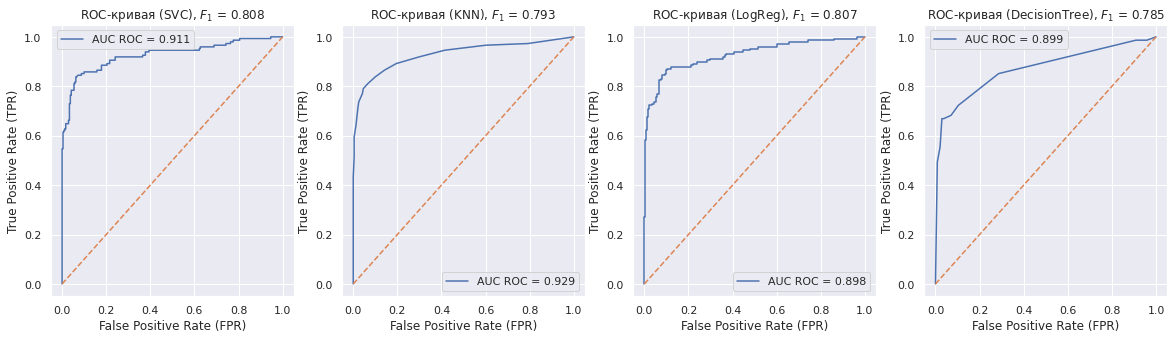

In [227]:
grids = [
    ('SVC', randomized_search_svc),
    ('KNN', randomized_search_knn),
    ('LogReg', randomized_search_logreg),
    ('DecisionTree', randomized_search_tree),
]


fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.flatten()


for idx, gr in enumerate(grids):
    fpr, tpr, threshold = roc_curve(y_test, gr[1].predict_proba(X_test)[:,1])

    ax[idx].plot(fpr, tpr)
    ax[idx].plot([0, 1], [0, 1], '--')
    ax[idx].set_title(f"ROC-кривая ({gr[0]}), $F_1$ = {gr[1].best_score_.round(3)}")
    ax[idx].set_xlabel('False Positive Rate (FPR)')
    ax[idx].legend([f'AUC ROC = {roc_auc_score(y_train, gr[1].predict_proba(X_train)[:,1]).round(3)}'])
    ax[idx].set_ylabel('True Positive Rate (TPR)');

Итак, была выбрана метрика F1 для оценки качества модели на кросс-валидации, потому что наблюдается явный дисбаланс классов. Предпочтение какому-либо классу не отдается, поэтому важно минимизировать ка кошибки I рода, так и II рода. Также для итоговых моделей была выполнена оценка AUC ROC.

Следует отметить, что пайплайн для SVC показал себя наиболее хорошо на кросс-валидации, второй по качеству пайплайн с логистической регрессией. Будем использовать для моделирования именно пайплайн SVC

In [228]:
best_model = randomized_search_svc.best_estimator_.named_steps['models']
preprocessor = randomized_search_svc.best_estimator_.named_steps['preprocessor']
features = map(lambda x: x.split('__')[1], preprocessor.get_feature_names_out())
features = list(map(lambda x: x.split('_')[1] if len(x.split('_')) > 1 else x, features))

In [229]:
features

['Косметика и аксесуары',
 'Кухонная посуда',
 'Мелкая бытовая техника и электроника',
 'Техника для красоты и здоровья',
 'Товары для детей',
 'неоплаченные категория',
 'Маркет актив 6 мес',
 'Акционные покупки',
 'Средний просмотр категорий за визит',
 'Ошибка сервиса',
 'Страниц за визит',
 'предыдущий месяц (минуты)',
 'предыдущий месяц (выручка)',
 'препредыдущий месяц (выручка)']

In [230]:
X = pd.DataFrame(data=preprocessor.transform(X_test), columns=features)

In [231]:
X.columns

Index(['Косметика и аксесуары', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника',
       'Техника для красоты и здоровья', 'Товары для детей',
       'неоплаченные категория', 'Маркет актив 6 мес', 'Акционные покупки',
       'Средний просмотр категорий за визит', 'Ошибка сервиса',
       'Страниц за визит', 'предыдущий месяц (минуты)',
       'предыдущий месяц (выручка)', 'препредыдущий месяц (выручка)'],
      dtype='object')

## Анализ важности признаков

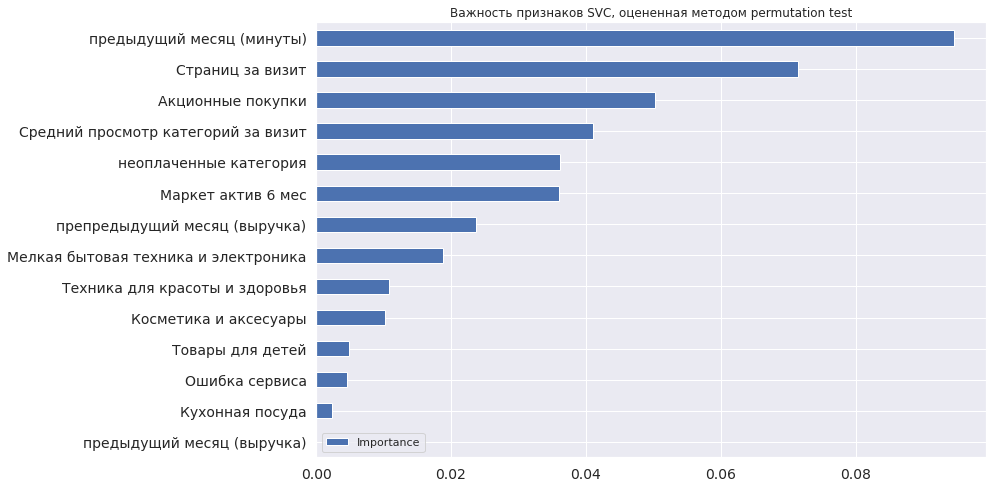

In [232]:
warnings.filterwarnings("ignore", category=UserWarning)
result = permutation_importance(best_model, X, y_test, scoring='f1')

feature_importance = pd.DataFrame({'Feature': features, 'Importance': np.abs(result['importances_mean'])})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(12, 8), ylabel='', xlabel='', fontsize=14, title='Важность признаков SVC, оцененная методом permutation test')
plt.show()

- Итак, видим, что отклик модели наибольший при изменении признака `предыдущий месяц (минуты)`.
- Наименьший - `Ошибка сервиса`.
- Следует также отметить, что среди популярных категорий наиболее влиятельной оказалась категории `Мелкая бытовая техника и электроника`, а также `Техника для красоты и здоровья`

Теперь посмотрим на анализ значений Шепли. Значений в тестовом датасете всего 325, однако метод shap.KernelExplainer невероятно ресурсоемок, поэтому выделим подвыборку методом отложенной выборки в размере 30% от общего размера тестовой выборки и посмотрим на значения. Также будем проводить стратификацию подвыборки

In [233]:
_, X_shap, _, y_shap = train_test_split(X, y_test, random_state=RANDOM_STATE, stratify=y_test, test_size=.3)

In [234]:
# X_shap = shap.sample(X, 50)
explainer = shap.KernelExplainer(randomized_search_svc.best_estimator_.named_steps['models'].predict, X_shap)
shap_values = explainer(X_shap)

Using 117 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/117 [00:00<?, ?it/s]

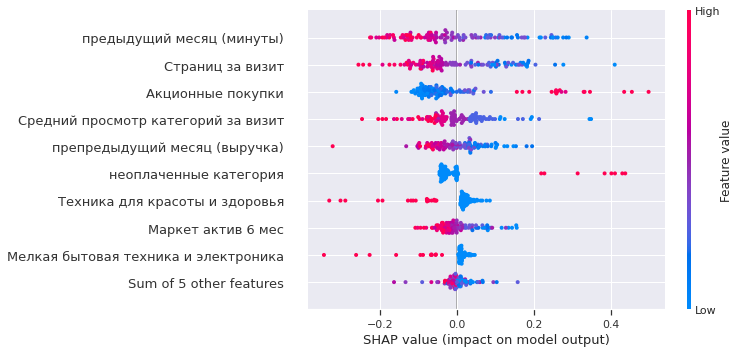

In [235]:
ax = shap.plots.beeswarm(shap_values) 

Отметим, что слева находится класс "Прежний уровень", справа - "Снизится"

In [236]:
label_encoder.classes_, label_encoder.transform(label_encoder.classes_)

(array(['Прежний уровень', 'Снизилась'], dtype=object), array([0, 1]))

- Чем больше минут клиент провел в предыдущем месяце на сайте магазина, тем более уверенно модель относит его к классу "Прежний уровень"
- Клиентов с высокой долей акционных покупок модель склонна относить к классу "Снизится"
- Много страниц за визит связано с сохранением активности, мало — с ее снижением
- Чем больше категорий просматривает клиент, тем больше вероятность, что он останется активным
- Если человек уже тратил деньги ранее (в препредыдущем месяце), он скорее останется активным. 
- Клиенты, интересующиеся мелкой и бытовой техникой, а также техникой для красоты и здоровья сохраняют активность
- Модель склонна относить клиентов с высокой маркетинговой активностью за полгода к сохраняющим активность

Следует отметить большое сходство с тестом на перестановку

Для сравнения также можно проинтерпретировать значения Шепли для пайплайна с логистической регрессией

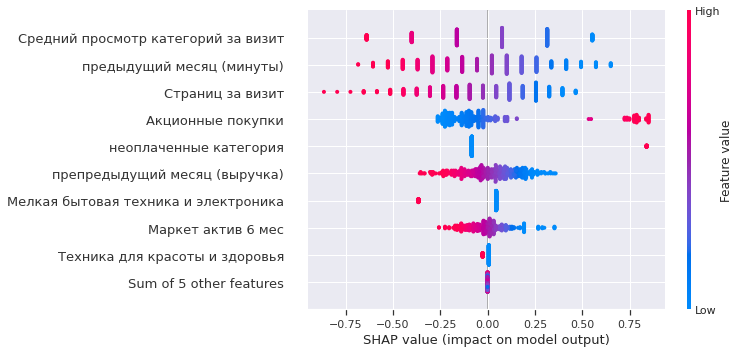

In [237]:
explainer = shap.LinearExplainer(randomized_search_logreg.best_estimator_.named_steps['models'], X)
shap_values = explainer(X)

shap.plots.beeswarm(shap_values) 

Видно, что логистическая регрессия делает те же выводы по признакам, однако стоит отметить, что для данной модели важность признаков ранжируется иначе чем для пайплайна с SVM

## Отбор признаков

In [238]:
results = []
    
f1s = []
roc_aucs = []
precs = []
recalls = []
accs = []

for i in range(0, len(features), 1):

        p = Pipeline([
    ('preprocessor', randomized_search_svc.best_estimator_.named_steps['preprocessor']),
    ('selector', SelectKBest(f_classif, k=i+1)),
    ('models', randomized_search_svc.best_estimator_.named_steps['models']),
    ])
    
        p.fit(X_train, y_train)
    
        preds = p.predict(X_test)
        preds_probs = p.predict_proba(X_test)[:,1]
        
        

        f1s.append(f1_score(y_test, preds))
        roc_aucs.append(roc_auc_score(y_test, preds_probs))
        precs.append(precision_score(y_test, preds))
        recalls.append(recall_score(y_test, preds))
        accs.append(accuracy_score(y_test, preds))
    
        results.append(("SVC", {'recall': recalls, 
                               'precision': precs, 
                               'auc_roc': roc_aucs, 
                               'F1': f1s, 
                               'accuracy': accs}))

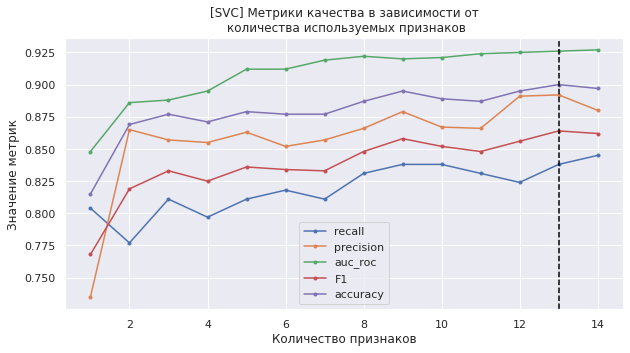

In [241]:
scores = pd.DataFrame(results[0][1], index=np.arange(1, 15, 1)).round(3)
scores.plot(marker='.', title=f'[{results[0][0]}] Метрики качества в зависимости от\n количества используемых признаков', figsize=(10, 5));
plt.axvline(x=scores.index[scores['F1'].argmax()], ymax=1, ls='--', color='black')
plt.xlabel('Количество признаков')
plt.ylabel('Значение метрик');

Итак, заметно, что лучшие результаты по-прежнему показывает SVC-пайплайн. Максимальное значение метрики $F_1=0.864$ достигается при $k=13$
Посмотрим на результаты при различных k для SVC

In [242]:
scores = pd.DataFrame(results[0][1], index=np.arange(1, len(features) + 1, 1)).round(3)
scores

,recall,precision,auc_roc,F1,accuracy
1,0.804,0.735,0.848,0.768,0.815
2,0.777,0.865,0.886,0.819,0.869
3,0.811,0.857,0.888,0.833,0.877
4,0.797,0.855,0.895,0.825,0.871
5,0.811,0.863,0.912,0.836,0.879
6,0.818,0.852,0.912,0.834,0.877
7,0.811,0.857,0.919,0.833,0.877
8,0.831,0.866,0.922,0.848,0.887
9,0.838,0.879,0.920,0.858,0.895
10,0.838,0.867,0.921,0.852,0.889


In [243]:
p = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(f_classif, k=13)),
    ('models', randomized_search_svc.best_estimator_.named_steps['models']),
    ])

p.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Популярная категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strat...
                                                  Index(['Маркет актив 6 мес', 'Акционные покупки',
       'Средний просмотр категорий за визит', 'Ошибка сервиса',
       'Страниц за визит', 'предыдущий месяц (минуты)',
       'предыдущий месяц (выручка)', 'препредыдущий месяц (выручка)'],
      dtype='object'))])),
                ('selector', SelectKBest(k=13)),
                ('models',
                 SVC(C=np.float64(0.24000000000000002), class_weight='balanced',
                     probability=True, random_state=42))])

In [244]:
p['selector'].get_feature_names_out(features)

array(['Косметика и аксесуары', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника',
       'Техника для красоты и здоровья', 'Товары для детей',
       'неоплаченные категория', 'Маркет актив 6 мес',
       'Акционные покупки', 'Средний просмотр категорий за визит',
       'Ошибка сервиса', 'Страниц за визит', 'предыдущий месяц (минуты)',
       'препредыдущий месяц (выручка)'], dtype=object)

Видим знакомые признаки из анализа важности

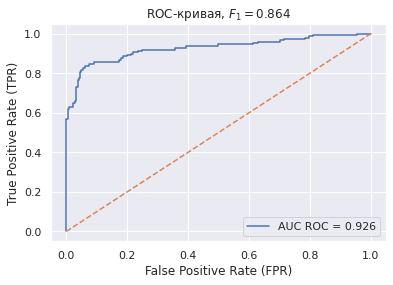

In [245]:
fpr, tpr, threshold = roc_curve(y_test, p.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.title(f"ROC-кривая, $F_1={round(f1_score(y_test, p.predict(X_test)), 3)}$")
plt.xlabel('False Positive Rate (FPR)')
plt.legend([f'AUC ROC = {roc_auc_score(y_test, p.predict_proba(X_test)[:,1]).round(3)}'])
plt.ylabel('True Positive Rate (TPR)');

Итак, окончательная модель - SVC с 13 признаками, оценкой $F^{\text{test}}_1=0.864$. Ниже представлен итоговый пайплайн

In [300]:
p

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Популярная категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strat...
                                                 ('num', MinMaxScaler(),
                                                  Index(['Маркет актив 6 мес', 'Акционные покупки',
       'Средний просмотр категорий за визит', 'Ошибка сервиса',
       'Страниц за визит', 'предыдущий месяц (минуты)',
       'предыдущий месяц (выручка)', 'препредыдущий месяц (выручка)'],
      dtype='object'))])),
                ('selector', SelectKBest(k=13)),
                ('models',
                 SVC(C=0.24000000000000002, class_weight='balanced',
                     probability=True, random_state=42))])

## Исследование сегментов

In [246]:
df_profit = full_df.join(money.set_index('id'), how='inner')

In [247]:
df_profit.head()

,Покупательская активность,Маркет актив 6 мес,Акционные покупки,Популярная категория,Средний просмотр категорий за визит,Ошибка сервиса,Страниц за визит,неоплаченные категория,предыдущий месяц (минуты),предыдущий месяц (выручка),препредыдущий месяц (выручка),Прибыль
id,,,,,,,,,,,,
215349,Снизилась,4.4,0.75,Товары для детей,4,2,5,мало,12,5216.0,4472.0,4.16
215350,Снизилась,4.9,0.14,Домашний текстиль,5,1,5,мало,8,5457.5,4826.0,3.13
215351,Снизилась,3.2,0.99,Товары для детей,5,6,4,мало,11,6158.0,4793.0,4.87
215352,Снизилась,5.1,0.94,Товары для детей,3,3,2,мало,8,5807.5,4594.0,4.21
215353,Снизилась,3.3,0.26,Домашний текстиль,4,1,4,мало,10,4738.5,5124.0,3.95


In [248]:
df_profit['user_activity_class_prob'] = p.predict_proba(df_profit)[:, 1]

In [249]:
df_profit['user_activity_class_label'] = label_encoder.inverse_transform(p.predict(df_profit))

In [250]:
df_profit.head()

,Покупательская активность,Маркет актив 6 мес,Акционные покупки,Популярная категория,Средний просмотр категорий за визит,Ошибка сервиса,Страниц за визит,неоплаченные категория,предыдущий месяц (минуты),предыдущий месяц (выручка),препредыдущий месяц (выручка),Прибыль,user_activity_class_prob,user_activity_class_label
id,,,,,,,,,,,,,,
215349,Снизилась,4.4,0.75,Товары для детей,4,2,5,мало,12,5216.0,4472.0,4.16,0.865921,Снизилась
215350,Снизилась,4.9,0.14,Домашний текстиль,5,1,5,мало,8,5457.5,4826.0,3.13,0.509341,Снизилась
215351,Снизилась,3.2,0.99,Товары для детей,5,6,4,мало,11,6158.0,4793.0,4.87,0.881534,Снизилась
215352,Снизилась,5.1,0.94,Товары для детей,3,3,2,мало,8,5807.5,4594.0,4.21,0.966435,Снизилась
215353,Снизилась,3.3,0.26,Домашний текстиль,4,1,4,мало,10,4738.5,5124.0,3.95,0.731936,Снизилась


In [251]:
df_profit['segment_1'] = (
    (df_profit['user_activity_class_prob'] >= .6) & 
    (df_profit['Акционные покупки'] >= .8)).astype(int)

df_profit['segment_2'] = (
    df_profit['Популярная категория'].isin(['Мелкая бытовая техника и электроника', 
                                            'Техника для красоты и здоровья'])).astype(int)

### Сегмент №1 (Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности)

In [252]:
phik_overview = (df_profit
                 .query('segment_1 == 1')
                 .drop(columns=['user_activity_class_label', 
                                'Покупательская активность', 
                                'segment_1', 
                                'segment_2', 
                                'segment_3'], 
                       errors='ignore')
                 .phik_matrix()
                )

(phik_overview[['user_activity_class_prob']]
 .drop(index='user_activity_class_prob')
 .sort_values('user_activity_class_prob'))

interval columns not set, guessing: ['Маркет актив 6 мес', 'Акционные покупки', 'Средний просмотр категорий за визит', 'Ошибка сервиса', 'Страниц за визит', 'предыдущий месяц (минуты)', 'предыдущий месяц (выручка)', 'препредыдущий месяц (выручка)', 'Прибыль', 'user_activity_class_prob']


,user_activity_class_prob
Прибыль,0.000000
предыдущий месяц (выручка),0.000000
Маркет актив 6 мес,0.028803
Ошибка сервиса,0.138072
неоплаченные категория,0.246890
Акционные покупки,0.333655
Средний просмотр категорий за визит,0.455815
Популярная категория,0.508244
препредыдущий месяц (выручка),0.534131
Страниц за визит,0.606704


- Видим, что больше всего на вероятность снижения активности влияют `предыдущий месяц (минуты)`, `препредыдущий месяц (выручка)`, `Страниц за визит`

In [253]:
num_cols = [
           'предыдущий месяц (минуты)', 
           'препредыдущий месяц (выручка)', 
           'Страниц за визит',
           'предыдущий месяц (выручка)', 
           'Маркет актив 6 мес', 
           'Акционные покупки', 
           'Средний просмотр категорий за визит', 
           'Ошибка сервиса', 
           ]

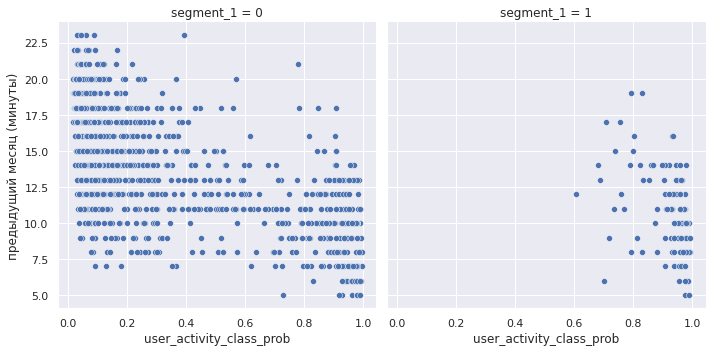

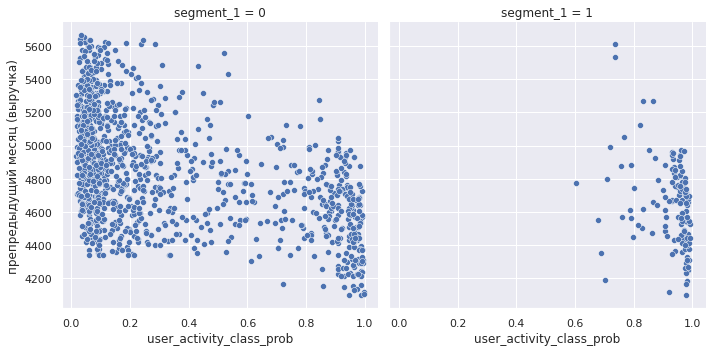

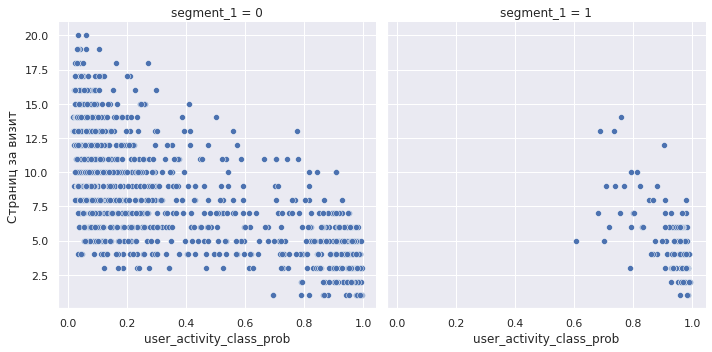

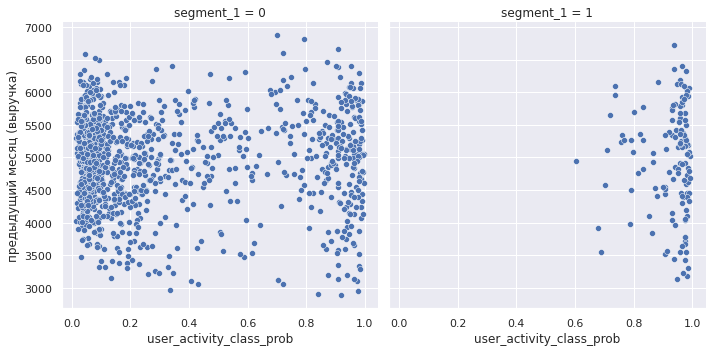

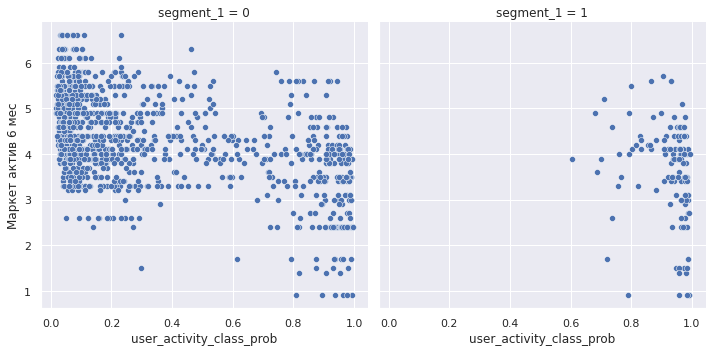

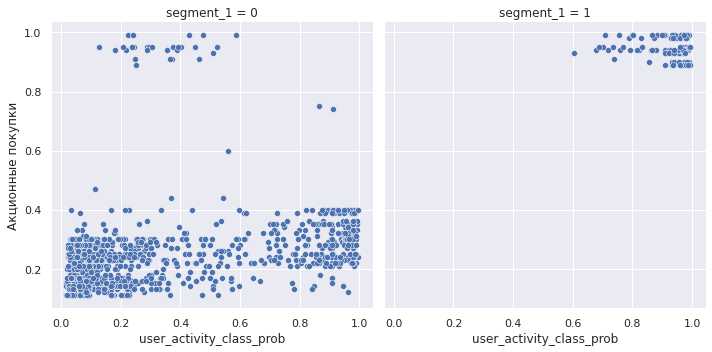

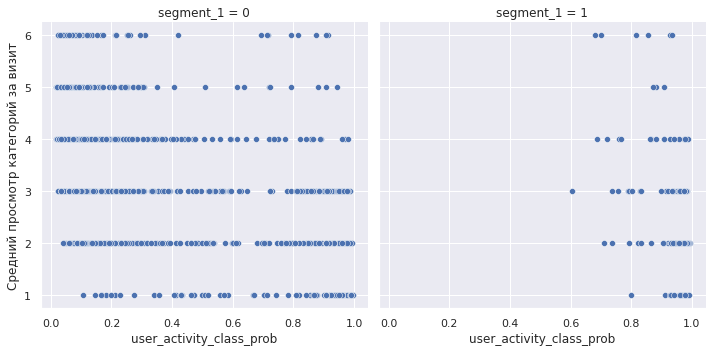

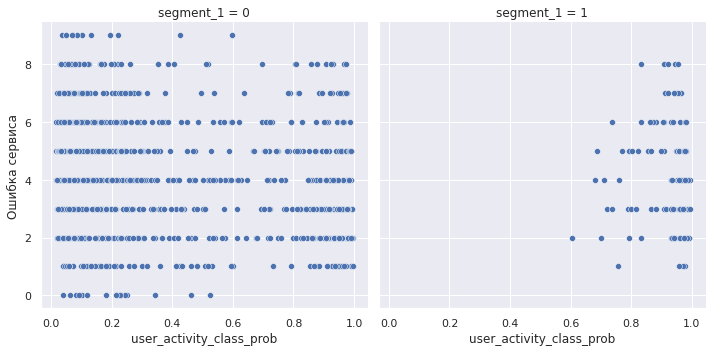

In [254]:
for i, col in enumerate(num_cols):
    sns.relplot(
        data=df_profit, 
        x='user_activity_class_prob', 
        y=col, 
        col='segment_1')

- Заметно, что для больших акционных процентов при количестве страниц за визит менее 7 классификатор считает, что вероятнее всего покупательская активность снизится. Причем чем меньше страниц, тем более классификатор увереннее относит покупателя к классу `Снизится`
- Кроме того, в этом сегменте акционных покупок при выручке за предпредыдущий месяц меньше 5000 классификатор скорее относит покупателя к классу `Снизится`
- На решение классификатора также влияет время, проведенное в магазине за предыдущий месяц, чем меньше времени провел в прошлом месяце клиент, тем более классификатор уверен, что покупательская активность снизится

In [255]:
df_profit.pivot_table(index='Популярная категория', columns='segment_1', values=['user_activity_class_prob'], aggfunc='median')

user_activity_class_prob          
segment_1                                                   0         1
Популярная категория                                                   
Домашний текстиль                                    0.112790  0.963916
Косметика и аксесуары                                0.312356  0.961958
Кухонная посуда                                      0.391905  0.939596
Мелкая бытовая техника и электроника                 0.068098  0.798660
Техника для красоты и здоровья                       0.123174  0.909629
Товары для детей                                     0.186601  0.966160

In [256]:
df_profit.pivot_table(index='неоплаченные категория', columns='segment_1', values=['user_activity_class_prob'], aggfunc='median')

user_activity_class_prob          
segment_1                                     0         1
неоплаченные категория                                   
мало                                   0.135878  0.958902
много                                  0.946722  0.957662

- Видим, что потенциально привлекательные категории - Мелкая бытовая техника и электроника, Техника для красоты и здоровья. Судя по медианным значениям, клиенты этих категорий чаще остаются активными вне зависимости от акционных периодов. Однако акции могут расширить сегмент покупателей. Возможно, есть смысл предлагать расширенные гарантии, подходящие аксессуары и дополнящие товары (особенно для Техника для красоты и здоровья) и даже trade-in программы. 
- В остальных категориях наблюдается сильная зависимость от акций. Причем акционная политика не приводит к удержанию интереса клиентов. После заверешения акций клиенты уходят. Здесь возможны следующие шаги по стимулированию:
    - Персонализированные скидки
    - Бонусные программы
    - Подписки на регулярные покупки
- По-возможности нужно бороться с застоями неоплаченных товаров в корзине - делать push-уведомления
- Есть повод задуматься над возможным изменением стратегии. Вместо резких акционных скачков в цене внедрять кэшбэк, накопительные и бонусные программы и тд.

### Сегмент №2 (Группа клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом.)

In [257]:
phik_overview = (df_profit
                 .query('segment_2 == 1')
                 .drop(columns=['user_activity_class_label', 
                                'Покупательская активность', 
                                'segment_1', 
                                'segment_2', 
                                'segment_3'], 
                       errors='ignore')
                 .phik_matrix()
                )

(phik_overview[['user_activity_class_prob']]
 .drop(index='user_activity_class_prob')
 .sort_values('user_activity_class_prob').round(2))

interval columns not set, guessing: ['Маркет актив 6 мес', 'Акционные покупки', 'Средний просмотр категорий за визит', 'Ошибка сервиса', 'Страниц за визит', 'предыдущий месяц (минуты)', 'предыдущий месяц (выручка)', 'препредыдущий месяц (выручка)', 'Прибыль', 'user_activity_class_prob']


,user_activity_class_prob
Прибыль,0.00
Ошибка сервиса,0.22
Популярная категория,0.33
препредыдущий месяц (выручка),0.45
предыдущий месяц (выручка),0.45
Средний просмотр категорий за визит,0.47
Акционные покупки,0.55
Маркет актив 6 мес,0.56
Страниц за визит,0.57
предыдущий месяц (минуты),0.63


В техническом сегменте наблюдается очень сильная взаимосвязь вероятности снижения активности от количества неоплаченных товаров в корзине

In [258]:
df_profit.pivot_table(index='Популярная категория', columns='segment_2', values=['user_activity_class_prob'], aggfunc='median').fillna(-1).round(2)

user_activity_class_prob      
segment_2                                                   0     1
Популярная категория                                               
Домашний текстиль                                        0.16 -1.00
Косметика и аксесуары                                    0.45 -1.00
Кухонная посуда                                          0.54 -1.00
Мелкая бытовая техника и электроника                    -1.00  0.07
Техника для красоты и здоровья                          -1.00  0.13
Товары для детей                                         0.24 -1.00

В техническом сегменте вероятность снижения активности достаточно низкая

In [259]:
df_profit.pivot_table(index='неоплаченные категория', columns='segment_2', values=['user_activity_class_prob'], aggfunc=['median', 'count']).round(2)

median        \
                       user_activity_class_prob         
segment_2                                     0     1   
неоплаченные категория                                  
мало                                       0.23  0.09   
много                                      0.96  0.92   

                                          count       
                       user_activity_class_prob       
segment_2                                     0    1  
неоплаченные категория                                
мало                                        847  337  
много                                        93   19

Необходимо бороться с застоями товаров в корзине, например, напоминать через push

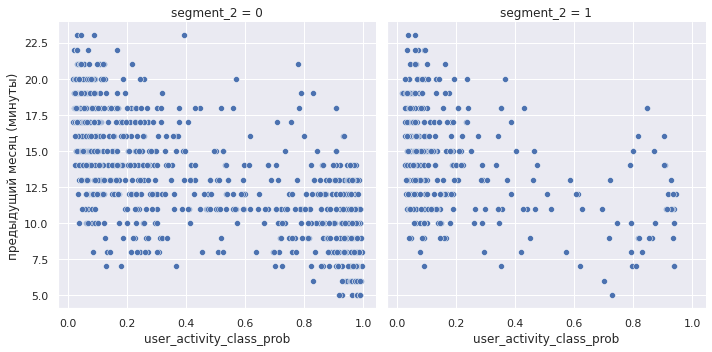

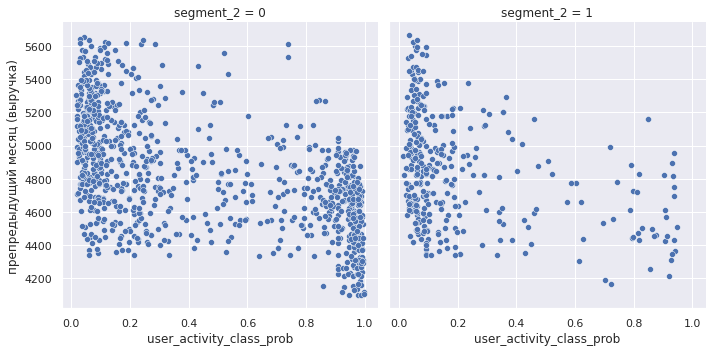

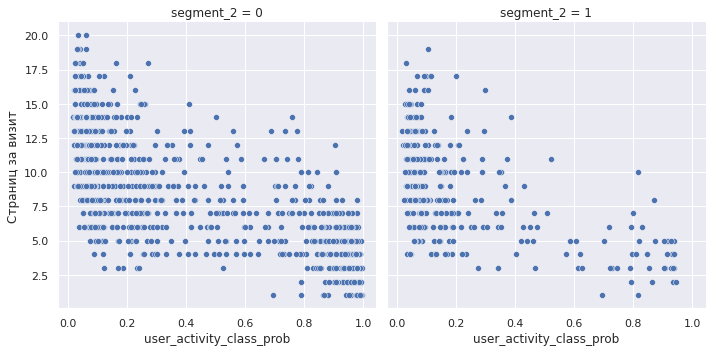

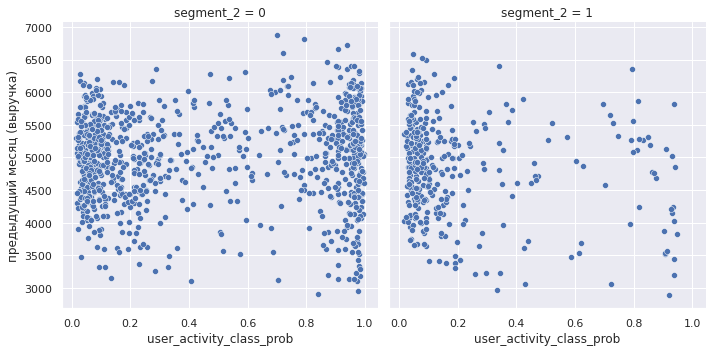

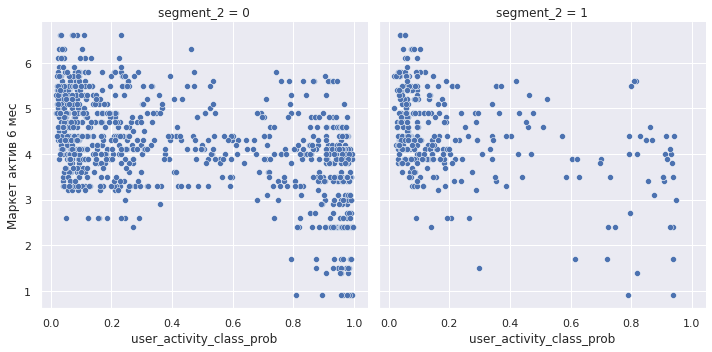

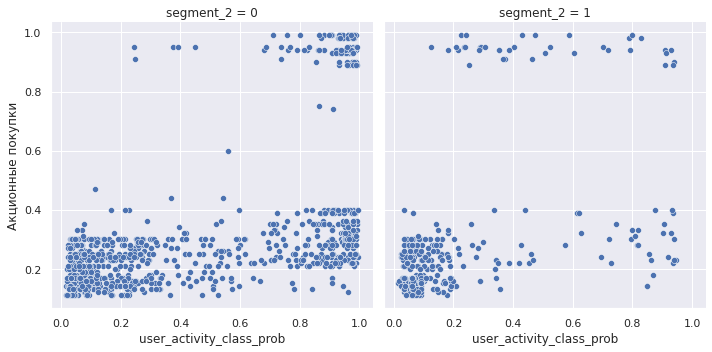

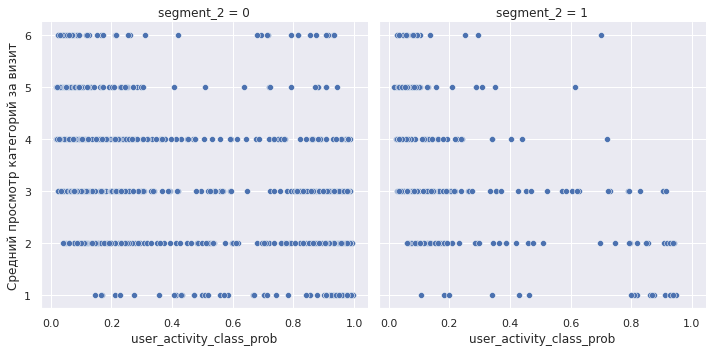

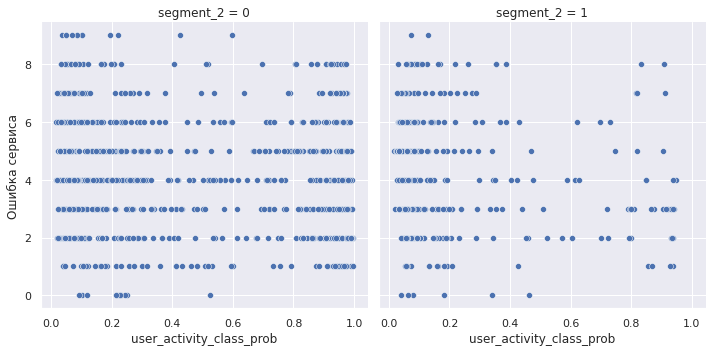

In [260]:
for i, col in enumerate(num_cols):
    sns.relplot(
        data=df_profit, 
        x='user_activity_class_prob', 
        y=col, 
        col='segment_2')

- Выбор техники требует большой вовлеченности, поэтому наблюдается значительная связь с поведенческими признаками клиента, чем больше страниц и времени потрачено, тем ниже вероятность снижения активности
- При умеренной (до 4) маркетинговой активности высока вероятность снижения интереса у клиента.
- Клиенты, сохраняющие активность в этом сегменте, смотрят как правило больше категорий за один визит
- Есть определенная взаимосвязь и с потраченными деньгами в позапрошлом месяце. У снизивших активность клиентов траты были в большинстве случаев до 5к


- Здесь стоит внимательнее следить за системой оповещения о спецпредложениях, внедрять персонализированные предложения, однако подходить к усилению маркетингового натиска нужно индивидуально, чтобы стимулировать клиента, а не отпугивать
- Также работать над рекомендательной системой. Предлагать больше дополнящих товаров (Добавить блоки рекомендаций "С этим товаром покупают", возможно даже ввести систему комплектов для изучения смежных категорий как внутри сегмента, так и вне), чтобы провоцировать клиента просматривать больше категорий товаров
- В случае низкой финансовой активности клиента за определенный период делать push-напоминания и специальные предложения (бонусы, персональные акции)

## Итоговый вывод

- Датасеты не содержат пропусков и явных дубликатов, однако в `market_file` обнаружены неявные дубликаты (тип сервиса). Названия столбцов скорректированы: удалены подчеркивания, но кириллица сохранена. В данных по выручке найден значительный выброс. Подготовлены сводные таблицы для `market_time` и `market_money` по периодам.

- Исследовательский анализ показал, что снижение покупательской активности чаще наблюдается у клиентов с низким уровнем маркетингового воздействия, высоким процентом акционных покупок, небольшим числом просмотренных категорий и страниц за визит, а также при наличии неоплаченных товаров. Тип сервиса и разрешение на рассылку практически не влияют на активность. Премиальный сервис чаще выбирают долгосрочные клиенты, а большинство пользователей предпочитают стандартное обслуживание. Самая популярная категория – `Товары для детей`, наименее популярная – `Кухонная посуда`

- Был проведен корреляционный анализ. Некоторые признаки, такие как `текущий месяц (выручка)`, `Разрешить сообщать` и `Маркет актив тек мес`, не влияют на целевой признак. Признаки, связанные с текущим месяцем (`текущий месяц (минуты)`, `текущий месяц (выручка)`), исключены из-за риска утечки данных, поскольку они недоступны для предсказания будущей активности. Также удалены `Неоплаченные продукты штук квартал` и `группа акционных покупок` из-за сильной корреляции с их дублерами, которые оказывают большее влияние на целевой признак.

- Затем был подобран оптимальный пайплайн, обученный и оцененной на кросс-валидации. Им оказался пайплайн с моделью опорных векторов и нормализующим инструментом MinMaxScaler. В качестве метрики качества была использована $F_1$, так как таргет-переменная не является сбалансированной. Предпочтение какому-либо классу не отдается, поэтому важно минимизировать ка кошибки I рода, так и II рода. Также для итоговых моделей была выполнена оценка AUC ROC.

- Для нивелирования воздействия дисбаланса применялось автоматическое взвешивание данных с помощью параметра моделей `class_weight='balanced'`

- Далее был проведен анализ важности признаков. Permutation test показал, что наиболее значимый признак — предыдущий месяц (минуты), а наименее значимый — Ошибка сервиса. Среди популярных категорий наибольшее влияние оказывают "Мелкая бытовая техника и электроника" и "Техника для красоты и здоровья". SHAP-анализ подтвердил, что большее время на сайте в прошлом месяце и просмотр множества категорий повышают вероятность сохранения активности. Высокая доля акционных покупок и малое число страниц за визит связаны со снижением активности. Если клиент тратил деньги ранее, он, скорее всего, останется активным. Активная маркетинговая кампания за полгода также способствует удержанию.

- Анализ сегментов показал, что в сегменте 1 (клиенты с высокой вероятностью снижения активности и большим процентом акционных покупок) ключевыми факторами падения активности являются низкое количество просмотренных страниц за визит (менее 7), небольшие траты в позапрошлом месяце (менее 5000) и малое время, проведенное на сайте в прошлом месяце. Чем меньше эти показатели, тем выше вероятность снижения покупательской активности. В сегменте 2 (технический, клиенты чаще покупают технику) поведенческие характеристики играют более важную роль. Выбор техники требует вовлеченности, поэтому чем больше клиент тратит времени на сайте и чем больше страниц просматривает, тем ниже вероятность падения активности. Однако при умеренной маркетинговой активности (до 4 касаний) интерес может снижаться. Также у клиентов, потерявших активность, траты в позапрошлом месяце чаще были менее 5000.

Для удержания клиентов в обоих сегментах необходимо оптимизировать маркетинговые коммуникации, внедряя персонализированные предложения и систему напоминаний о спецпредложениях. Важно усовершенствовать рекомендательную систему, добавляя блоки "С этим товаром покупают" и комплекты товаров для изучения смежных категорий. Для клиентов с низкой финансовой активностью за определенный период можно использовать push-уведомления и персонализированные бонусы.